In [1]:
from pathlib import Path
from urllib.request import urlretrieve

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import requests
from typing import Dict, List, Union, Optional

import pandas as pd
import geopandas as gpd

In [2]:
POST_DIR = Path(".").resolve()

The US Census bureau collects and publishes a massive amount of interesting data, including a lot of rich geospatial data. I want to integrate a lot of these datasets into my personal [analytics data warehouse](https://github.com/MattTriano/analytics_data_where_house/tree/main), and in this notebook, I'm going to work on scraping down metadata from geospatial-file-related pages on the Census's [file server](https://www2.census.gov/).

I'm also a big fan of `Geopandas`, and I'll show off some of the things it can do in this notebook.

In [3]:
def request_page(metadata_url: str) -> requests.models.Response:
    resp = requests.get(metadata_url)
    if resp.status_code == 200:
        return resp
    else:
        raise Exception(f"Couldn't get page metadata for url {metadata_url}")

def scrape_census_ftp_metadata_page(metadata_url: str) -> pd.DataFrame:
    resp = request_page(metadata_url=metadata_url)
    soup = BeautifulSoup(resp.content, "html.parser")
    table = soup.find("table")
    rows = table.find_all("tr")
    table_contents = []
    for row in rows:
        cols = row.find_all("td")
        cols = [col.text.strip() for col in cols]
        table_contents.append(cols)
    table_rows = [el for el in table_contents if len(el) > 0]

    metadata_df = pd.DataFrame(
        [row[1:] for row in table_rows],
        columns=["name", "last_modified", "size", "description"],
    )
    metadata_df["last_modified"] = pd.to_datetime(metadata_df["last_modified"])
    metadata_df["is_dir"] = metadata_df["name"].str.endswith("/")
    metadata_df["clean_name"] = metadata_df["name"].str.replace("/$", "", regex=True)
    metadata_df["is_file"] = (~metadata_df["is_dir"]) & (
        metadata_df["clean_name"] != "Parent Directory"
    )
    while metadata_url.strip().endswith("/"):
        metadata_url = metadata_url[:-1]
    mask = metadata_df["is_file"] | metadata_df["is_dir"]
    metadata_df = metadata_df.loc[mask].copy()
    metadata_df["metadata_url"] = (metadata_url + "/" + metadata_df["clean_name"])
    return metadata_df

In [4]:
tiger_url = "https://www2.census.gov/geo/tiger/"
metadata_url = tiger_url
tiger_top_level_df = scrape_census_ftp_metadata_page(metadata_url=metadata_url)

In [5]:
tiger_top_level_df = tiger_top_level_df.sort_values(by="last_modified", ascending=False, ignore_index=True)

In [6]:
print(tiger_top_level_df.shape)
tiger_top_level_df.head(10)

(60, 8)


name       last_modified size description  is_dir  clean_name  \
0    GENZ2020/ 2023-05-18 20:05:00    -                True    GENZ2020   
1    GENZ2022/ 2023-04-17 14:38:00    -                True    GENZ2022   
2    TIGER_DP/ 2023-03-16 11:50:00    -                True    TIGER_DP   
3  TGRGDBRD18/ 2023-01-26 15:28:00    -                True  TGRGDBRD18   
4    TGRGDB18/ 2023-01-26 11:49:00    -                True    TGRGDB18   
5  TIGER_RD18/ 2022-12-05 15:10:00    -                True  TIGER_RD18   
6   TIGER2022/ 2022-11-01 08:09:00    -                True   TIGER2022   
7   TIGER2021/ 2022-09-01 12:16:00    -                True   TIGER2021   
8    TGRGDB21/ 2022-08-02 14:48:00    -                True    TGRGDB21   
9    TGRGDB22/ 2022-08-02 14:12:00    -                True    TGRGDB22   

   is_file                                  metadata_url  
0    False    https://www2.census.gov/geo/tiger/GENZ2020  
1    False    https://www2.census.gov/geo/tiger/GENZ2022  
2    False    https://www2.census.gov/geo/tiger/TIGER_DP  
3    False  https://www2.census.gov/geo/tiger/TGRGDBRD18  
4    False    https://www2.census.gov/geo/tiger/TGRGDB18  
5    False  https://www2.census.gov/geo/tiger/TIGER_RD18  
6    False   https://www2.census.gov/geo/tiger/TIGER2022  
7    False   https://www2.census.gov/geo/tiger/TIGER2021  
8    False    https://www2.census.gov/geo/tiger/TGRGDB21  
9    False    https://www2.census.gov/geo/tiger/TGRGDB22

In [7]:
tiger_data_dictionary_df = tiger_top_level_df.loc[tiger_top_level_df["is_file"]].copy()
tiger_data_dictionary_df

name       last_modified  size description  \
17  Directory_Contents_ReadMe.pdf 2019-06-25 09:13:00  439K               

    is_dir                     clean_name  is_file  \
17   False  Directory_Contents_ReadMe.pdf     True   

                                         metadata_url  
17  https://www2.census.gov/geo/tiger/Directory_Co...

In [8]:
def download_file_from_single_row_metadata_df(file_df: pd.DataFrame, output_dir: Path = POST_DIR) -> Path:
    file_name = file_df["clean_name"].values[0]
    url = file_df["metadata_url"].values[0]
    print(f"file name: {file_name}")
    print(f"url:       {url}")
    file_outpath = output_dir.joinpath(file_name)
    if not file_outpath.is_file():
        urlretrieve(url, file_outpath)
    return file_outpath

In [9]:
_ = download_file_from_single_row_metadata_df(file_df=tiger_data_dictionary_df)

file name: Directory_Contents_ReadMe.pdf
url:       https://www2.census.gov/geo/tiger/Directory_Contents_ReadMe.pdf


There's not too much additional information in the TIGER subdirectory contents pdf, but I did learn that the `GENZ....` prefix is used exclusively for "Cartographic Boundary Files".

In [10]:
tiger_top_level_df.loc[tiger_top_level_df["name"].str.contains("2022")]

name       last_modified size description  is_dir clean_name  \
1   GENZ2022/ 2023-04-17 14:38:00    -                True   GENZ2022   
6  TIGER2022/ 2022-11-01 08:09:00    -                True  TIGER2022   

   is_file                                 metadata_url  
1    False   https://www2.census.gov/geo/tiger/GENZ2022  
6    False  https://www2.census.gov/geo/tiger/TIGER2022

In [11]:
tiger22_url = tiger_top_level_df.loc[
    tiger_top_level_df["clean_name"] == "TIGER2022", "metadata_url"
].values[0]
tiger22_url

'https://www2.census.gov/geo/tiger/TIGER2022'

In [12]:
tiger22_df = scrape_census_ftp_metadata_page(metadata_url=tiger22_url)

In [13]:
print(f"Rows in TIGER 2022 page scrapings: {len(tiger22_df)}")
tiger22_df = tiger22_df.sort_values(by="last_modified", ascending=False, ignore_index=True)
tiger22_df.head(10)

Rows in TIGER 2022 page scrapings: 45


name       last_modified size description  is_dir clean_name  \
0        UAC/ 2023-05-11 10:21:00    -                True        UAC   
1         CD/ 2023-05-09 15:41:00    -                True         CD   
2       PUMA/ 2022-10-31 19:47:00    -                True       PUMA   
3  SUBBARRIO/ 2022-09-30 22:39:00    -                True  SUBBARRIO   
4    POINTLM/ 2022-09-30 22:39:00    -                True    POINTLM   
5      PLACE/ 2022-09-30 22:39:00    -                True      PLACE   
6    FACESAL/ 2022-09-30 22:39:00    -                True    FACESAL   
7       SLDL/ 2022-09-30 22:39:00    -                True       SLDL   
8       SLDU/ 2022-09-30 22:39:00    -                True       SLDU   
9     ESTATE/ 2022-09-30 22:39:00    -                True     ESTATE   

   is_file                                       metadata_url  
0    False    https://www2.census.gov/geo/tiger/TIGER2022/UAC  
1    False     https://www2.census.gov/geo/tiger/TIGER2022/CD  
2    False   https://www2.census.gov/geo/tiger/TIGER2022/PUMA  
3    False  https://www2.census.gov/geo/tiger/TIGER2022/SU...  
4    False  https://www2.census.gov/geo/tiger/TIGER2022/PO...  
5    False  https://www2.census.gov/geo/tiger/TIGER2022/PLACE  
6    False  https://www2.census.gov/geo/tiger/TIGER2022/FA...  
7    False   https://www2.census.gov/geo/tiger/TIGER2022/SLDL  
8    False   https://www2.census.gov/geo/tiger/TIGER2022/SLDU  
9    False  https://www2.census.gov/geo/tiger/TIGER2022/ES...

This page has one file (a PDF). Let's download it and take a look.

In [14]:
tiger22_pdf_df = tiger22_df.loc[tiger22_df["is_file"]].copy()
tiger22_pdf_df

name       last_modified size  \
44  2022_TL_Shapefiles_File_Name_Definitions.pdf 2022-09-01 12:11:00  97K   

   description  is_dir                                    clean_name  is_file  \
44               False  2022_TL_Shapefiles_File_Name_Definitions.pdf     True   

                                         metadata_url  
44  https://www2.census.gov/geo/tiger/TIGER2022/20...

In [15]:
_ = download_file_from_single_row_metadata_df(file_df=tiger22_pdf_df)

file name: 2022_TL_Shapefiles_File_Name_Definitions.pdf
url:       https://www2.census.gov/geo/tiger/TIGER2022/2022_TL_Shapefiles_File_Name_Definitions.pdf


Looking at that PDF, I see that it decodes the names from the scraped tiger2022 page. Some interesting or relevant recodings:

* ADDR: Address Range Relationship File
* ADDRFEAT: Address Range Feature
* ADDRFN" Address Range-Feature Name Relationship
* AREALM Area Landmark
* AREAWATER: Area Hydrography
* COASTLINE: Coastline
* FEATNAMES: Feature Names Relationship File
* LINEARWATER: Linear Hydrography
* POINTLM: Point Landmark
* PRIMARYROADS: Primary Roads
* PRISECROADS: Primary and Secondary Roads
* PUMA20: 2020 Public Use Microdata Area
* RAILS: Rails
* ROADS: All Roads
* TRACT: Census Tract

In [16]:
tiger22_addresses_url = tiger22_df.loc[tiger22_df["name"] == "ADDR/", "metadata_url"].values[0]
tiger22_address_features_url = tiger22_df.loc[tiger22_df["name"] == "ADDRFEAT/", "metadata_url"].values[0]
tiger22_address_feature_names_url = tiger22_df.loc[tiger22_df["name"] == "ADDRFN/", "metadata_url"].values[0]
tiger22_area_landmarks_url = tiger22_df.loc[tiger22_df["name"] == "AREALM/", "metadata_url"].values[0]
tiger22_point_landmarks_url = tiger22_df.loc[tiger22_df["name"] == "POINTLM/", "metadata_url"].values[0]
tiger22_feature_names_url = tiger22_df.loc[tiger22_df["name"] == "FEATNAMES/", "metadata_url"].values[0]
tiger22_water_url = tiger22_df.loc[tiger22_df["name"] == "AREAWATER/", "metadata_url"].values[0]
tiger22_water_edges_url = tiger22_df.loc[tiger22_df["name"] == "LINEARWATER/", "metadata_url"].values[0]
tiger22_coastline_url = tiger22_df.loc[tiger22_df["name"] == "COASTLINE/", "metadata_url"].values[0]
tiger22_rails_url = tiger22_df.loc[tiger22_df["name"] == "RAILS/", "metadata_url"].values[0]
tiger22_roads_url = tiger22_df.loc[tiger22_df["name"] == "ROADS/", "metadata_url"].values[0]
tiger22_tract_url = tiger22_df.loc[tiger22_df["name"] == "TRACT/", "metadata_url"].values[0]

## Illinois Census Tracts

In [17]:
tiger22_tract_df = scrape_census_ftp_metadata_page(metadata_url=tiger22_tract_url)

The state FIPS code for Illinois is "17", so I'm going to download that.

In [18]:
tiger22_tract_df.head()

name       last_modified  size description  is_dir  \
1  tl_2022_01_tract.zip 2022-10-31 19:42:00   11M               False   
2  tl_2022_02_tract.zip 2022-10-31 19:42:00  3.0M               False   
3  tl_2022_04_tract.zip 2022-10-31 19:42:00  8.1M               False   
4  tl_2022_05_tract.zip 2022-10-31 19:42:00   10M               False   
5  tl_2022_06_tract.zip 2022-10-31 19:42:00   31M               False   

             clean_name  is_file  \
1  tl_2022_01_tract.zip     True   
2  tl_2022_02_tract.zip     True   
3  tl_2022_04_tract.zip     True   
4  tl_2022_05_tract.zip     True   
5  tl_2022_06_tract.zip     True   

                                        metadata_url  
1  https://www2.census.gov/geo/tiger/TIGER2022/TR...  
2  https://www2.census.gov/geo/tiger/TIGER2022/TR...  
3  https://www2.census.gov/geo/tiger/TIGER2022/TR...  
4  https://www2.census.gov/geo/tiger/TIGER2022/TR...  
5  https://www2.census.gov/geo/tiger/TIGER2022/TR...

In [19]:
il_tracts_df = tiger22_tract_df.loc[tiger22_tract_df["name"].str.contains("_17_")].copy()
il_tracts_df

name       last_modified  size description  is_dir  \
14  tl_2022_17_tract.zip 2022-10-31 19:43:00  9.5M               False   

              clean_name  is_file  \
14  tl_2022_17_tract.zip     True   

                                         metadata_url  
14  https://www2.census.gov/geo/tiger/TIGER2022/TR...

In [20]:
il_tracts_file_path = download_file_from_single_row_metadata_df(file_df=il_tracts_df)

file name: tl_2022_17_tract.zip
url:       https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_17_tract.zip


In [21]:
il_tract_gdf = gpd.read_file(il_tracts_file_path)

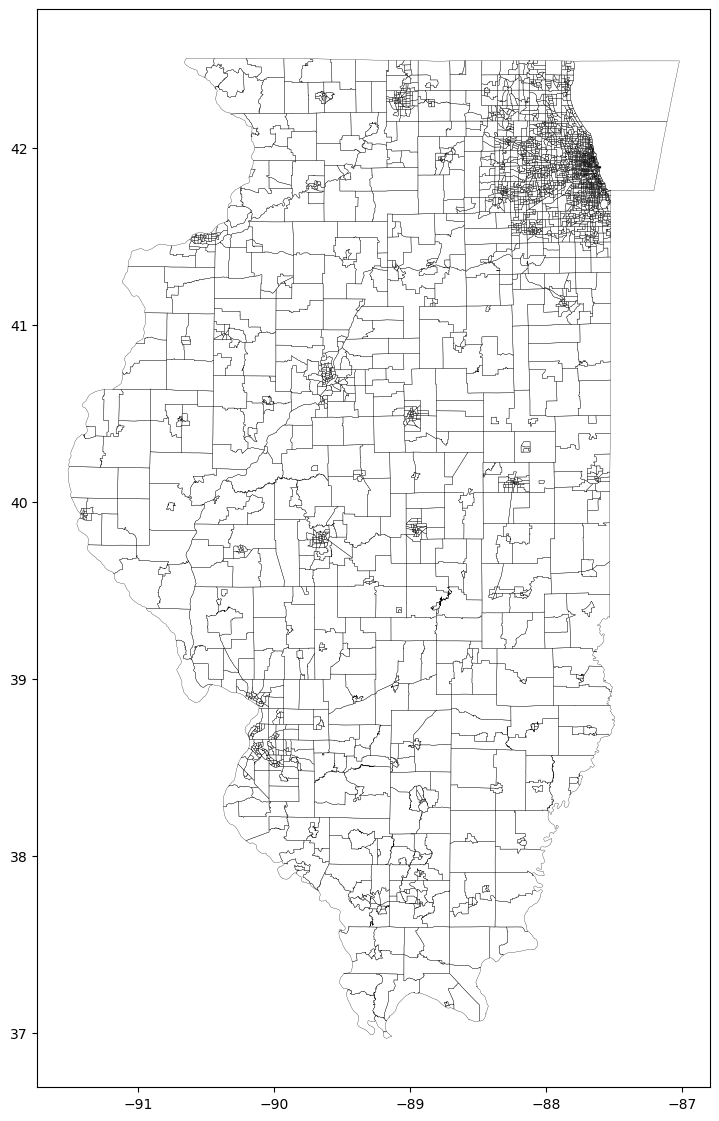

In [22]:
fig_width = 14

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = il_tract_gdf.plot(facecolor="none", edgecolor="black", linewidth=0.015 * fig_width, ax=ax)

Census tracts sized to have roughly comparable total populations. Looking at the tract boundaries on the map, it's neat to see all the little pockets of density across the state. Also, it's interesting to see just how much more densly populated Chicagoland is than the rest of the state; it doesn't feel so packed.

In [23]:
il_tract_gdf.head(2)

STATEFP COUNTYFP TRACTCE        GEOID    NAME             NAMELSAD  MTFCC  \
0      17      019  010701  17019010701  107.01  Census Tract 107.01  G5020   
1      17      019  005902  17019005902   59.02   Census Tract 59.02  G5020   

  FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  5266000   30553  +40.1150269  -088.0329549   
1        S   962402    4892  +40.1087344  -088.2247204   

                                            geometry  
0  POLYGON ((-88.05240 40.11923, -88.05238 40.119...  
1  POLYGON ((-88.22891 40.11271, -88.22882 40.112...

The County FIPS code for Cook County is "031". Let's plot out tracts in Cook County.

In [24]:
cc_tract_gdf = il_tract_gdf.loc[il_tract_gdf["COUNTYFP"] == "031"].copy()

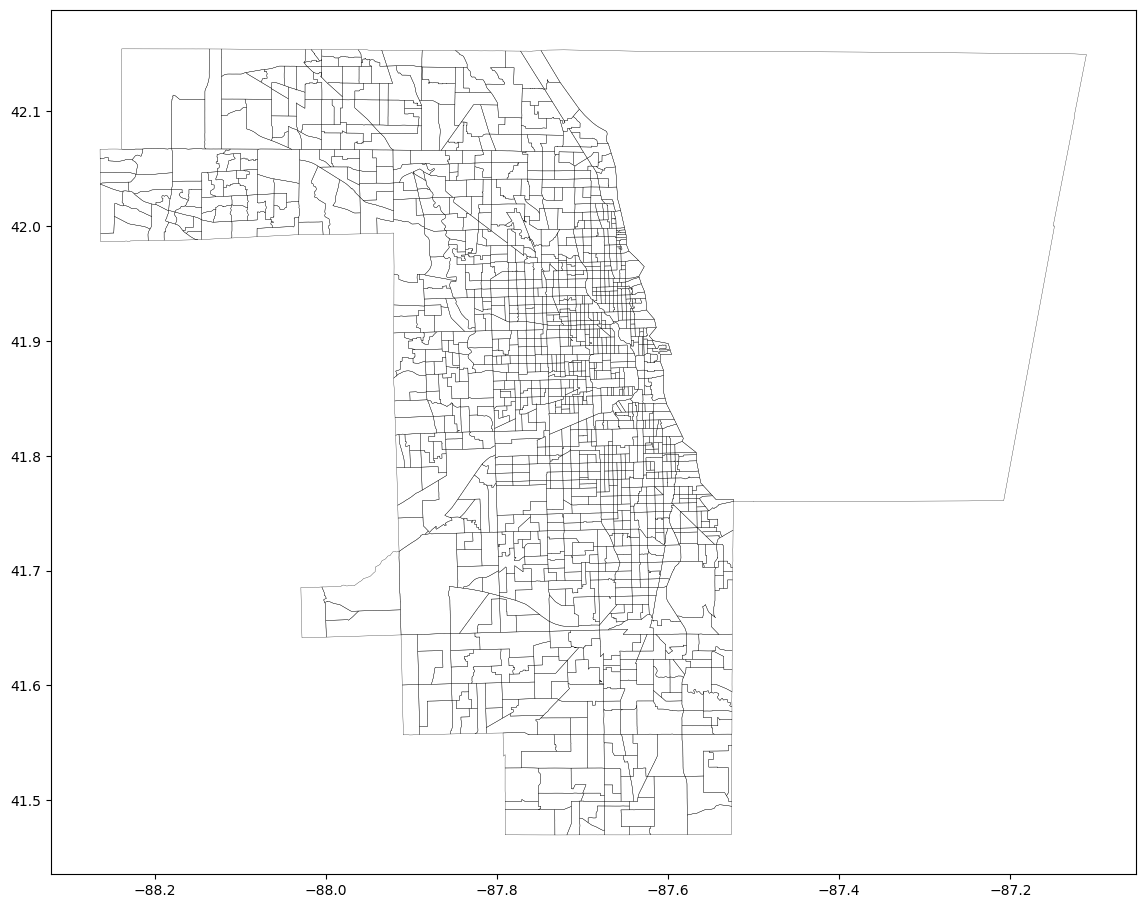

In [25]:
fig_width = 14

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = cc_tract_gdf.plot(facecolor="none", edgecolor="black", linewidth=0.015 * fig_width, ax=ax)

There are also filler tracts with essentially no population that just ensure all US land is covered by a tract.

That really large tract has no area on land, and a very large area over water. Let's filter that out.

In [26]:
cc_tract_gdf["ALAND"].min()

0

In [27]:
cc_tract_gdf.loc[cc_tract_gdf["ALAND"] == 0]

STATEFP COUNTYFP TRACTCE        GEOID  NAME           NAMELSAD  MTFCC  \
1531      17      031  990000  17031990000  9900  Census Tract 9900  G5020   

     FUNCSTAT  ALAND      AWATER     INTPTLAT      INTPTLON  \
1531        S      0  1717072182  +41.9739391  -087.4002947   

                                               geometry  
1531  POLYGON ((-87.74156 42.15323, -87.72176 42.153...

<Axes: >

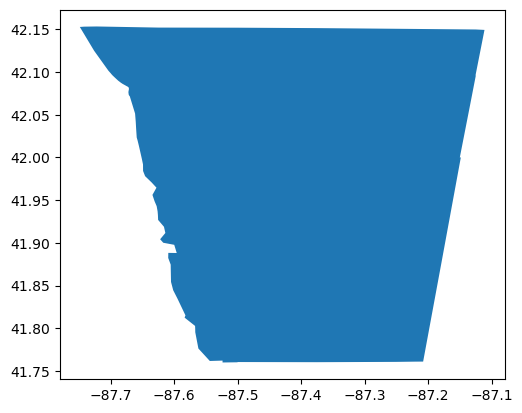

In [28]:
cc_tract_gdf.loc[cc_tract_gdf["ALAND"] == 0].plot()

In [29]:
cc_tract_land_gdf = cc_tract_gdf.loc[cc_tract_gdf["ALAND"] > 0].copy()

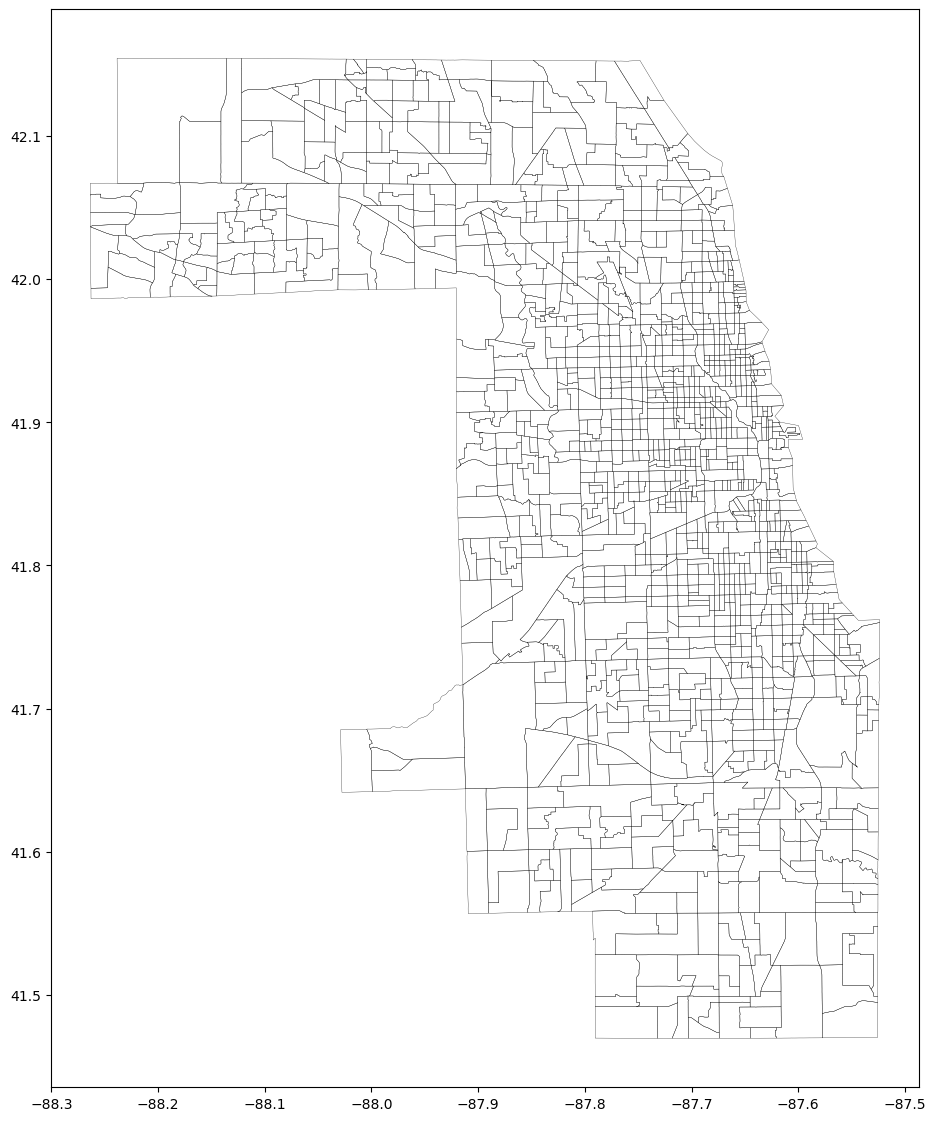

In [30]:
fig_width = 14

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = cc_tract_land_gdf.plot(facecolor="none", edgecolor="black", linewidth=0.015 * fig_width, ax=ax)

## US Rails

In [31]:
tiger22_rails_df = scrape_census_ftp_metadata_page(metadata_url=tiger22_rails_url)

In [32]:
print(tiger22_rails_df.shape)
tiger22_rails_df.head(2)

(1, 8)


name       last_modified size description  is_dir  \
1  tl_2022_us_rails.zip 2022-10-31 19:41:00  32M               False   

             clean_name  is_file  \
1  tl_2022_us_rails.zip     True   

                                        metadata_url  
1  https://www2.census.gov/geo/tiger/TIGER2022/RA...

In [33]:
rails22_file_path = download_file_from_single_row_metadata_df(file_df=tiger22_rails_df)

file name: tl_2022_us_rails.zip
url:       https://www2.census.gov/geo/tiger/TIGER2022/RAILS/tl_2022_us_rails.zip


In [34]:
rails22_gdf = gpd.read_file(rails22_file_path)

In [35]:
print(rails22_gdf.shape)
rails22_gdf.head(2)

(124883, 4)


LINEARID               FULLNAME  MTFCC  \
0  11020239500  Norfolk Southern Rlwy  R1011   
1  11020239501  Norfolk Southern Rlwy  R1011   

                                            geometry  
0  LINESTRING (-79.47058 35.44283, -79.46946 35.4...  
1  LINESTRING (-79.46687 35.44789, -79.46762 35.4...

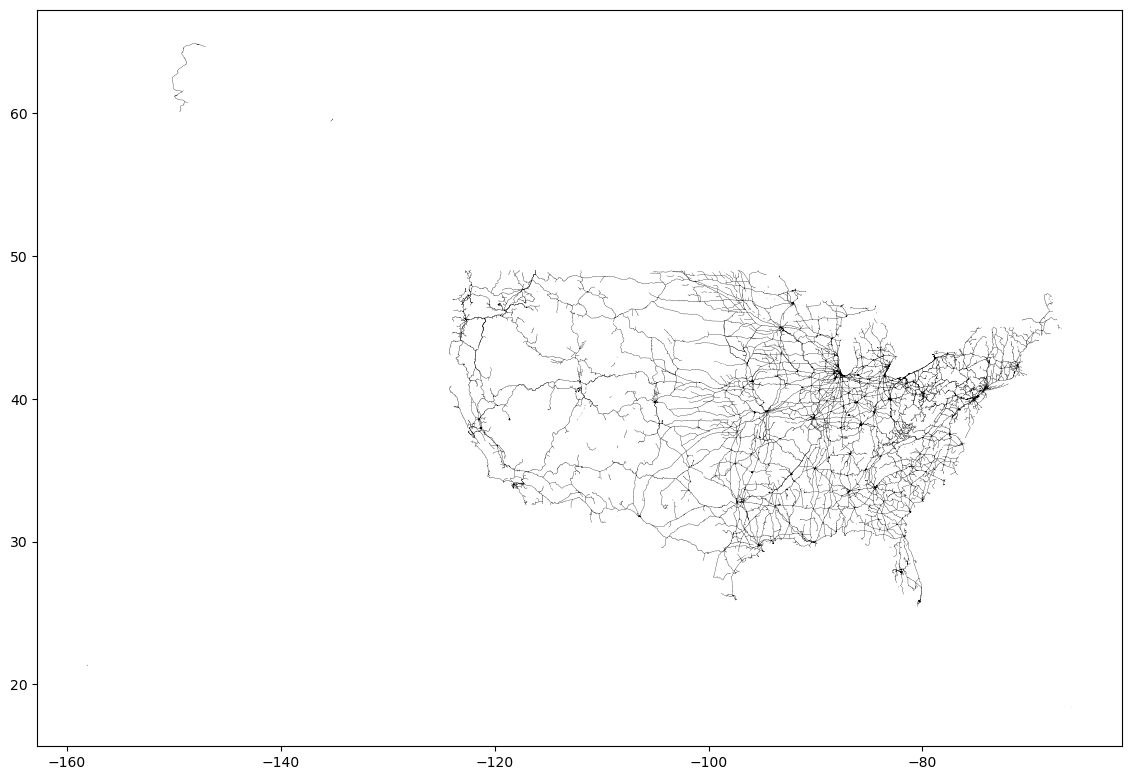

In [36]:
fig_width = 14

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = rails22_gdf.plot(facecolor="none", edgecolor="black", linewidth=0.015 * fig_width, ax=ax)

Ok, let's see if we can figure out a pattern in the ID values.

I can't tell if there's a pattern in the `LINEAR_ID` id values, but filtering on the extents of the geometries works well enough.

In [37]:
il_mask = (
    (rails22_gdf["geometry"].geometry.bounds.maxx > -91.5) &
    (rails22_gdf["geometry"].geometry.bounds.minx < -87) &
    (rails22_gdf["geometry"].geometry.bounds.miny > 36.8) &
    (rails22_gdf["geometry"].geometry.bounds.maxy < 42.5)
)
rails22_gdf.loc[il_mask]

LINEARID                             FULLNAME  MTFCC  \
2493       11062564039    Burlington Northern Santa Fe Rlwy  R1011   
2495       11062564041    Burlington Northern Santa Fe Rlwy  R1011   
2496       11062564042    Burlington Northern Santa Fe Rlwy  R1011   
2497       11062564043    Burlington Northern Santa Fe Rlwy  R1011   
2498       11062564044    Burlington Northern Santa Fe Rlwy  R1011   
...                ...                                  ...    ...   
124629  11030539241297               Indiana Harbor Belt RR  R1011   
124630  11030539241298  Chicago South Shore & South Bend RR  R1011   
124631  11030539241299  Chicago South Shore & South Bend RR  R1011   
124657  11030539624884                  Missouri Pacific RR  R1011   
124658  11030539624943                  Illinois Central RR  R1011   

                                                 geometry  
2493    LINESTRING (-91.43624 40.58459, -91.43717 40.5...  
2495    LINESTRING (-91.22472 40.71766, -91.22282 40.7...  
2496    LINESTRING (-91.40103 40.38701, -91.40241 40.3...  
2497    LINESTRING (-91.23146 40.70616, -91.23101 40.7...  
2498    LINESTRING (-91.22472 40.71766, -91.22478 40.7...  
...                                                   ...  
124629  LINESTRING (-87.52505 41.62898, -87.52568 41.6...  
124630  LINESTRING (-87.59632 41.70761, -87.59657 41.7...  
124631  LINESTRING (-87.60260 41.66973, -87.60255 41.6...  
124657  LINESTRING (-88.32004 39.78122, -88.32012 39.7...  
124658  LINESTRING (-88.30886 39.68084, -88.30897 39.6...  

[11949 rows x 4 columns]

Let's get the state boundary from those tract boundaries.

In [38]:
il_state_boundary = il_tract_gdf.loc[il_tract_gdf["ALAND"] > 0].copy()
il_state_boundary = il_state_boundary.dissolve(by="STATEFP")
il_state_boundary

geometry COUNTYFP TRACTCE  \
STATEFP                                                                       
17       POLYGON ((-90.37195 38.31979, -90.37160 38.321...      019  010701   

               GEOID    NAME             NAMELSAD  MTFCC FUNCSTAT    ALAND  \
STATEFP                                                                      
17       17019010701  107.01  Census Tract 107.01  G5020        S  5266000   

         AWATER     INTPTLAT      INTPTLON  
STATEFP                                     
17        30553  +40.1150269  -088.0329549

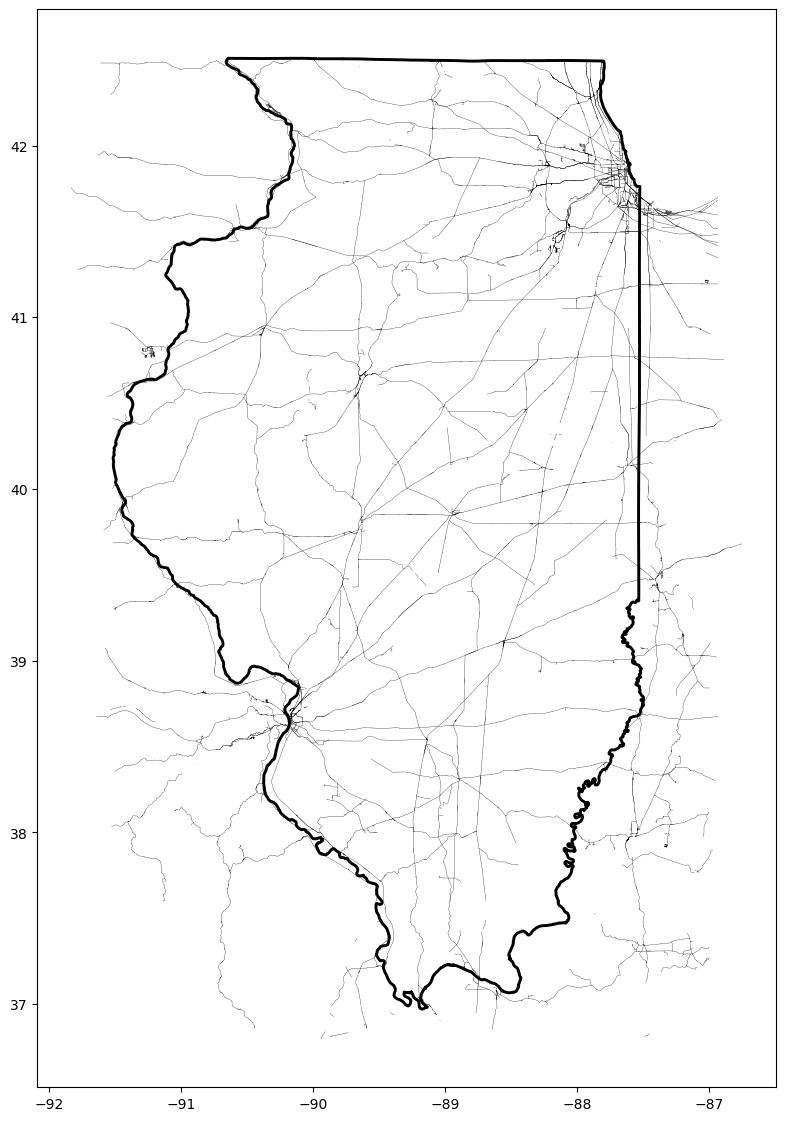

In [39]:
fig_width = 14

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = rails22_gdf.loc[il_mask].plot(facecolor="none", edgecolor="black", linewidth=0.015 * fig_width, ax=ax)
ax = il_state_boundary.plot(facecolor="none", edgecolor="black", linewidth=0.15 * fig_width, ax=ax)

In [40]:
rails22_gdf.head(2)

LINEARID               FULLNAME  MTFCC  \
0  11020239500  Norfolk Southern Rlwy  R1011   
1  11020239501  Norfolk Southern Rlwy  R1011   

                                            geometry  
0  LINESTRING (-79.47058 35.44283, -79.46946 35.4...  
1  LINESTRING (-79.46687 35.44789, -79.46762 35.4...

In [41]:
rails22_gdf["MTFCC"].value_counts(dropna=False)

MTFCC
R1011    124883
Name: count, dtype: int64

That's not very interesting. Maybe I should investigate that `FEATNAMES` file.

## Feature Names

In [42]:
tiger22_feature_names_url

'https://www2.census.gov/geo/tiger/TIGER2022/FEATNAMES'

In [43]:
tiger22_feat_names_df = scrape_census_ftp_metadata_page(metadata_url=tiger22_feature_names_url)

In [44]:
print(tiger22_feat_names_df.shape)
tiger22_feat_names_df.head(2)

(3235, 8)


name       last_modified  size description  is_dir  \
1  tl_2022_01001_featnames.zip 2022-10-31 16:05:00  300K               False   
2  tl_2022_01003_featnames.zip 2022-10-31 16:05:00  888K               False   

                    clean_name  is_file  \
1  tl_2022_01001_featnames.zip     True   
2  tl_2022_01003_featnames.zip     True   

                                        metadata_url  
1  https://www2.census.gov/geo/tiger/TIGER2022/FE...  
2  https://www2.census.gov/geo/tiger/TIGER2022/FE...

In [45]:
cc_feat_names_df = tiger22_feat_names_df.loc[tiger22_feat_names_df["name"].str.contains("_17031_")].copy()

In [46]:
cc_feat_names_file_path = download_file_from_single_row_metadata_df(file_df=cc_feat_names_df)

file name: tl_2022_17031_featnames.zip
url:       https://www2.census.gov/geo/tiger/TIGER2022/FEATNAMES/tl_2022_17031_featnames.zip


In [47]:
from zipfile import ZipFile

In [48]:
with ZipFile(cc_feat_names_file_path, "r") as zf:
    for fn in zf.filelist:
        print(fn)

<ZipInfo filename='tl_2022_17031_featnames.cpg' filemode='-rwxrwxr-x' file_size=5>
<ZipInfo filename='tl_2022_17031_featnames.dbf' compress_type=deflate filemode='-rwxrwxr-x' file_size=128309798 compress_size=5694237>
<ZipInfo filename='tl_2022_17031_featnames.shp.ea.iso.xml' compress_type=deflate filemode='-rwxrwxr-x' file_size=55251 compress_size=3165>
<ZipInfo filename='tl_2022_17031_featnames.shp.iso.xml' compress_type=deflate filemode='-rwxrwxr-x' file_size=39111 compress_size=5721>


Ok, so it's just a shapefile like everything else. I guess that makes sense. But it looks like none of the records have a non-null geometry value.

In any case, there's a `LINEARID` feature, just like in the rails data, so I suspect I'll be able to join this to records with linear geometries. And I assume `TLID` stands for "Topological" (maybe?).

In [49]:
cc_feat_names_gdf = gpd.read_file(cc_feat_names_file_path)

In [50]:
print(cc_feat_names_gdf.shape)
cc_feat_names_gdf.head(2)

(310676, 19)


TLID        FULLNAME   NAME PREDIRABRV PRETYPABRV PREQUALABR  \
0  111771547     47th Pl Exd   47th        NaN        NaN        NaN   
1  112385480  Edens Expy Spr  Edens        NaN        NaN        NaN   

  SUFDIRABRV SUFTYPABRV SUFQUALABR PREDIR PRETYP PREQUAL SUFDIR SUFTYP  \
0        NaN         Pl        Exd    NaN    NaN     NaN    NaN    472   
1        NaN       Expy        Spr    NaN    NaN     NaN    NaN    262   

  SUFQUAL       LINEARID  MTFCC PAFLAG geometry  
0      16   110380277026  S1400      A     None  
1      24  1104259027148  S1100      A     None

In [51]:
cc_feat_names_gdf["geometry"].notnull().sum()

0

## Roads

In [52]:
tiger22_roads_df = scrape_census_ftp_metadata_page(metadata_url=tiger22_roads_url)

In [53]:
print(tiger22_roads_df.shape)
tiger22_roads_df.head(2)

(3233, 8)


name       last_modified  size description  is_dir  \
1  tl_2022_01001_roads.zip 2022-10-31 16:05:00  937K               False   
2  tl_2022_01003_roads.zip 2022-10-31 16:05:00  2.2M               False   

                clean_name  is_file  \
1  tl_2022_01001_roads.zip     True   
2  tl_2022_01003_roads.zip     True   

                                        metadata_url  
1  https://www2.census.gov/geo/tiger/TIGER2022/RO...  
2  https://www2.census.gov/geo/tiger/TIGER2022/RO...

In [54]:
cc_roads22_df = tiger22_roads_df.loc[tiger22_roads_df["name"].str.contains("_17031_")].copy()
cc_roads22_df

name       last_modified size description  is_dir  \
613  tl_2022_17031_roads.zip 2022-10-31 16:46:00  14M               False   

                  clean_name  is_file  \
613  tl_2022_17031_roads.zip     True   

                                          metadata_url  
613  https://www2.census.gov/geo/tiger/TIGER2022/RO...

In [55]:
cc_roads22_file_path = download_file_from_single_row_metadata_df(file_df=cc_roads22_df)

file name: tl_2022_17031_roads.zip
url:       https://www2.census.gov/geo/tiger/TIGER2022/ROADS/tl_2022_17031_roads.zip


In [56]:
cc_roads22_gdf = gpd.read_file(cc_roads22_file_path)

In [57]:
print(cc_roads22_gdf.shape)
cc_roads22_gdf.head(2)

(76017, 5)


LINEARID        FULLNAME RTTYP  MTFCC  \
0   110380277026     47th Pl Exd     M  S1400   
1  1104259027148  Edens Expy Spr     M  S1100   

                                            geometry  
0  LINESTRING (-87.59577 41.81461, -87.59570 41.8...  
1  LINESTRING (-87.86543 42.14969, -87.86394 42.1...

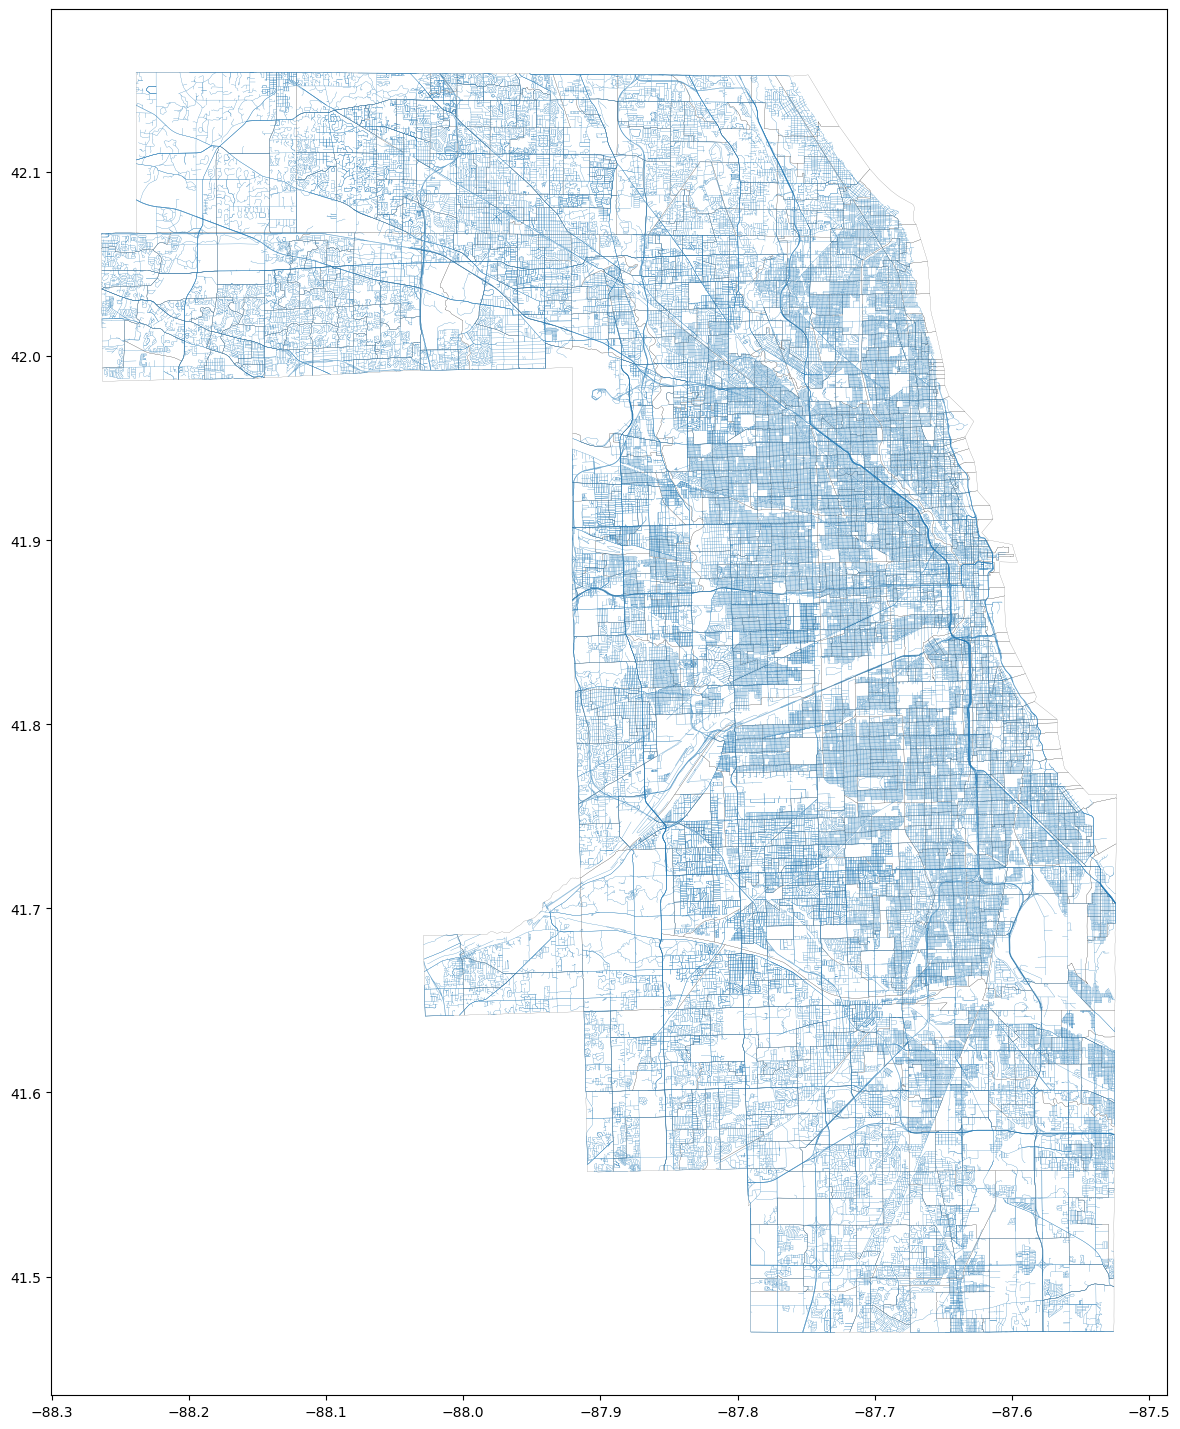

In [58]:
fig_width = 18

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = cc_tract_land_gdf.plot(facecolor="none", edgecolor="black", linewidth=0.005 * fig_width, ax=ax)
ax = cc_roads22_gdf.plot(linewidth=0.01 * fig_width, ax=ax)

In [59]:
cc_roads22_gdf.head(2)

LINEARID        FULLNAME RTTYP  MTFCC  \
0   110380277026     47th Pl Exd     M  S1400   
1  1104259027148  Edens Expy Spr     M  S1100   

                                            geometry  
0  LINESTRING (-87.59577 41.81461, -87.59570 41.8...  
1  LINESTRING (-87.86543 42.14969, -87.86394 42.1...

In [60]:
cc_roads22_gdf["MTFCC"].value_counts(dropna=False)

MTFCC
S1400    44317
S1730    22230
S1640     5442
S1630     1240
S1820      883
S1200      599
S1740      450
S1710      377
S1780      259
S1100      191
S1750       28
S1500        1
Name: count, dtype: int64

In [61]:
cc_roads22_gdf["RTTYP"].value_counts(dropna=False)

RTTYP
M      44839
NaN    30939
S        111
U         71
I         50
O          7
Name: count, dtype: int64

In [62]:
pd.crosstab(cc_roads22_gdf["RTTYP"], cc_roads22_gdf["MTFCC"])

MTFCC  S1100  S1200  S1400  S1500  S1640  S1710  S1730  S1740  S1780  S1820
RTTYP                                                                      
I         48      2      0      0      0      0      0      0      0      0
M        133    426  42395      1    612     26   1109    109     25      3
O          0      0      2      0      4      1      0      0      0      0
S          6    104      1      0      0      0      0      0      0      0
U          4     67      0      0      0      0      0      0      0      0

Hmm.

Based on counts, I infer that `RTTYP` value **M** probably stands for Main or Major or Municipal.

Based on the counts and the name scheme for `MTFCC`, I assume (and have confirmed below) that [`MTFCC` **S1100**, `RTTYP` **I**] referrs to Interstates.

In [63]:
cc_roads22_gdf.loc[
    (cc_roads22_gdf["MTFCC"] == "S1100") & (cc_roads22_gdf["RTTYP"] == "I")
].head()

LINEARID FULLNAME RTTYP  MTFCC  \
16532   1106087288978    I- 80     I  S1100   
16574   1109097585731   I- 294     I  S1100   
16919   1109097861222    I- 94     I  S1100   
16934  11015504130831    I- 90     I  S1100   
18127   1104493001200   I- 190     I  S1100   

                                                geometry  
16532  LINESTRING (-87.52528 41.57698, -87.52567 41.5...  
16574  LINESTRING (-87.91908 41.83601, -87.91904 41.8...  
16919  LINESTRING (-87.63614 41.84582, -87.63601 41.8...  
16934  LINESTRING (-87.62262 41.77505, -87.62338 41.7...  
18127  LINESTRING (-87.84814 41.98372, -87.84868 41.9...

Per a bit of googling, `MTFCC` stands for **MAF/TIGER Feature Class Codes** ([Source](https://www.census.gov/library/reference/code-lists/mt-feature-class-codes.html), which also provides code definitions).

Per the 2022 MTFCC Definition doc:
* **S1100**: Primary road
* **S1200**: Secondary road
* **S1400**: Local Neighborhood Road, Rural Road, City Street
...
There are also longer descriptions for all feature classes.

Also, `RTTYP` stands for **Route Type**, and the codes are decoded [here](https://www.census.gov/library/reference/code-lists/route-type-codes.html). It turns out that **M** stands for Co**m**mon Name.

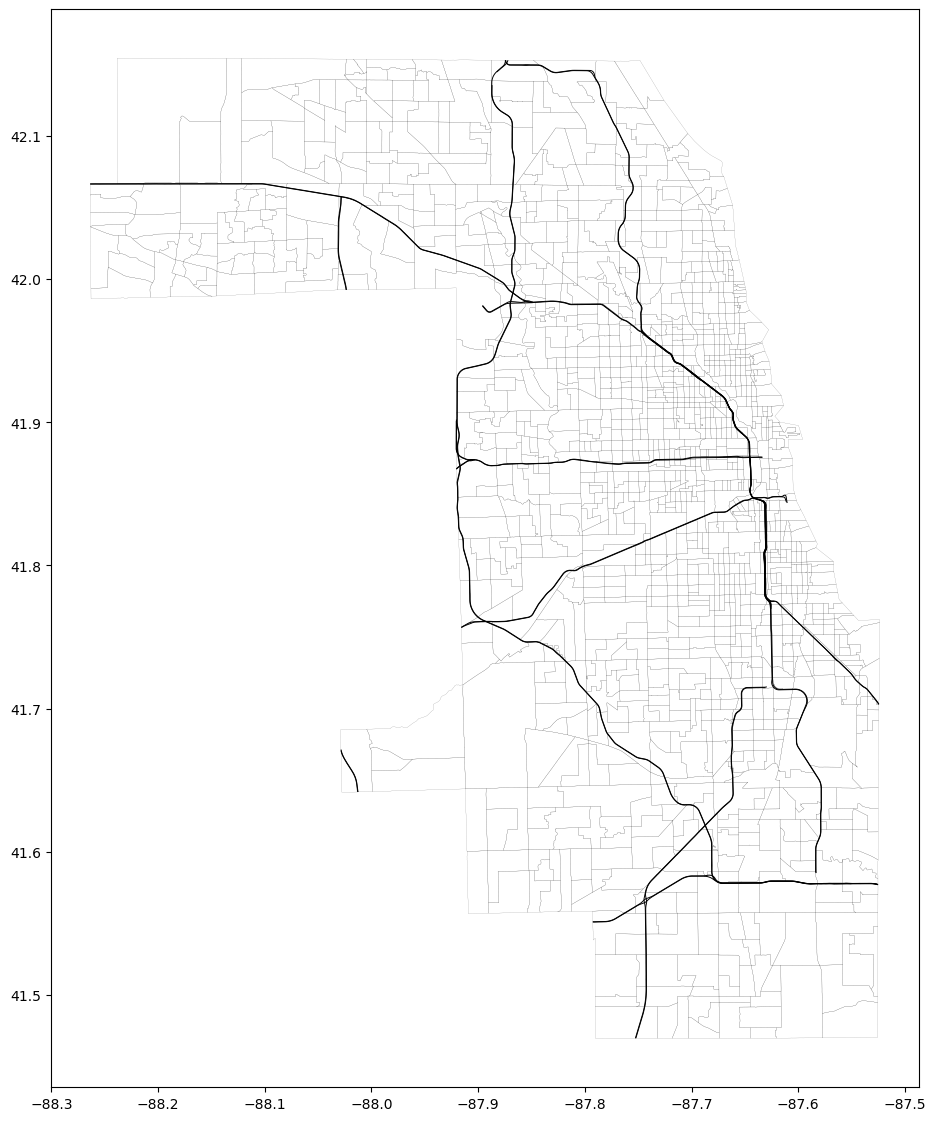

In [64]:
fig_width = 14

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = cc_roads22_gdf.loc[
    (cc_roads22_gdf["MTFCC"] == "S1100") & (cc_roads22_gdf["RTTYP"] == "I")
].plot(facecolor="none", edgecolor="black", linewidth=0.05 * fig_width, ax=ax)
ax = cc_tract_land_gdf.plot(facecolor="none", edgecolor="black", linewidth=0.005 * fig_width, ax=ax)

## Addresses

In [65]:
tiger22_addresses_df = scrape_census_ftp_metadata_page(metadata_url=tiger22_addresses_url)

In [66]:
print(tiger22_addresses_df.shape)
tiger22_addresses_df.head(2)

(3226, 8)


name       last_modified  size description  is_dir  \
1  tl_2022_01001_addr.zip 2022-10-31 16:05:00  103K               False   
2  tl_2022_01003_addr.zip 2022-10-31 16:05:00  507K               False   

               clean_name  is_file  \
1  tl_2022_01001_addr.zip     True   
2  tl_2022_01003_addr.zip     True   

                                        metadata_url  
1  https://www2.census.gov/geo/tiger/TIGER2022/AD...  
2  https://www2.census.gov/geo/tiger/TIGER2022/AD...

In [67]:
cc_addresses22_df = tiger22_addresses_df.loc[tiger22_addresses_df["name"].str.contains("_17031_")].copy()
cc_addresses22_df

name       last_modified  size description  is_dir  \
613  tl_2022_17031_addr.zip 2022-10-31 16:46:00  3.9M               False   

                 clean_name  is_file  \
613  tl_2022_17031_addr.zip     True   

                                          metadata_url  
613  https://www2.census.gov/geo/tiger/TIGER2022/AD...

In [68]:
cc_addresses22_file_path = download_file_from_single_row_metadata_df(file_df=cc_addresses22_df)

file name: tl_2022_17031_addr.zip
url:       https://www2.census.gov/geo/tiger/TIGER2022/ADDR/tl_2022_17031_addr.zip


In [69]:
cc_addresses22_gdf = gpd.read_file(cc_addresses22_file_path)

In [70]:
print(cc_addresses22_gdf.shape)
cc_addresses22_gdf.head(2)

(270921, 11)


TLID FROMHN  TOHN SIDE    ZIP  PLUS4 FROMTYP TOTYP           ARID  \
0  111689810   3987  3999    R  60192    NaN     NaN     I  4004702369138   
1  111689809   4001  4083    R  60192    NaN       I   NaN  4002320013208   

   MTFCC geometry  
0  D1000     None  
1  D1000     None

### Address Features

In [71]:
tiger22_addr_feats_df = scrape_census_ftp_metadata_page(metadata_url=tiger22_address_features_url)

In [72]:
print(tiger22_addr_feats_df.shape)
tiger22_addr_feats_df.head(2)

(3226, 8)


name       last_modified  size description  is_dir  \
1  tl_2022_01001_addrfeat.zip 2022-10-31 16:05:00  705K               False   
2  tl_2022_01003_addrfeat.zip 2022-10-31 16:05:00  2.2M               False   

                   clean_name  is_file  \
1  tl_2022_01001_addrfeat.zip     True   
2  tl_2022_01003_addrfeat.zip     True   

                                        metadata_url  
1  https://www2.census.gov/geo/tiger/TIGER2022/AD...  
2  https://www2.census.gov/geo/tiger/TIGER2022/AD...

In [73]:
cc_addr_feats22_df = tiger22_addr_feats_df.loc[tiger22_addr_feats_df["name"].str.contains("_17031_")].copy()
cc_addr_feats22_df

name       last_modified size description  is_dir  \
613  tl_2022_17031_addrfeat.zip 2022-10-31 16:46:00  16M               False   

                     clean_name  is_file  \
613  tl_2022_17031_addrfeat.zip     True   

                                          metadata_url  
613  https://www2.census.gov/geo/tiger/TIGER2022/AD...

In [74]:
cc_addr_feats22_file_path = download_file_from_single_row_metadata_df(file_df=cc_addr_feats22_df)

file name: tl_2022_17031_addrfeat.zip
url:       https://www2.census.gov/geo/tiger/TIGER2022/ADDRFEAT/tl_2022_17031_addrfeat.zip


In [75]:
cc_addr_feats22_gdf = gpd.read_file(cc_addr_feats22_file_path)

In [76]:
print(cc_addr_feats22_gdf.shape)
cc_addr_feats22_gdf.head(2)

(178057, 26)


TLID      TFIDL      TFIDR ARIDL         ARIDR       LINEARID  \
0  608944628  224940750  223761625   NaN  400198243134  1104492999121   
1  608944628  224940750  223761625   NaN  400198243134  1104492999533   

         FULLNAME LFROMHN LTOHN RFROMHN  ... PARITYR PLUS4L PLUS4R LFROMTYP  \
0   State Line Rd     NaN   NaN    1400  ...       E    NaN    NaN      NaN   
1  State Line Ave     NaN   NaN    1400  ...       E    NaN    NaN      NaN   

  LTOTYP RFROMTYP RTOTYP  OFFSETL  OFFSETR  \
0    NaN      NaN      I        N        N   
1    NaN      NaN      I        N        N   

                                            geometry  
0  LINESTRING (-87.52526 41.59370, -87.52538 41.5...  
1  LINESTRING (-87.52526 41.59370, -87.52538 41.5...  

[2 rows x 26 columns]

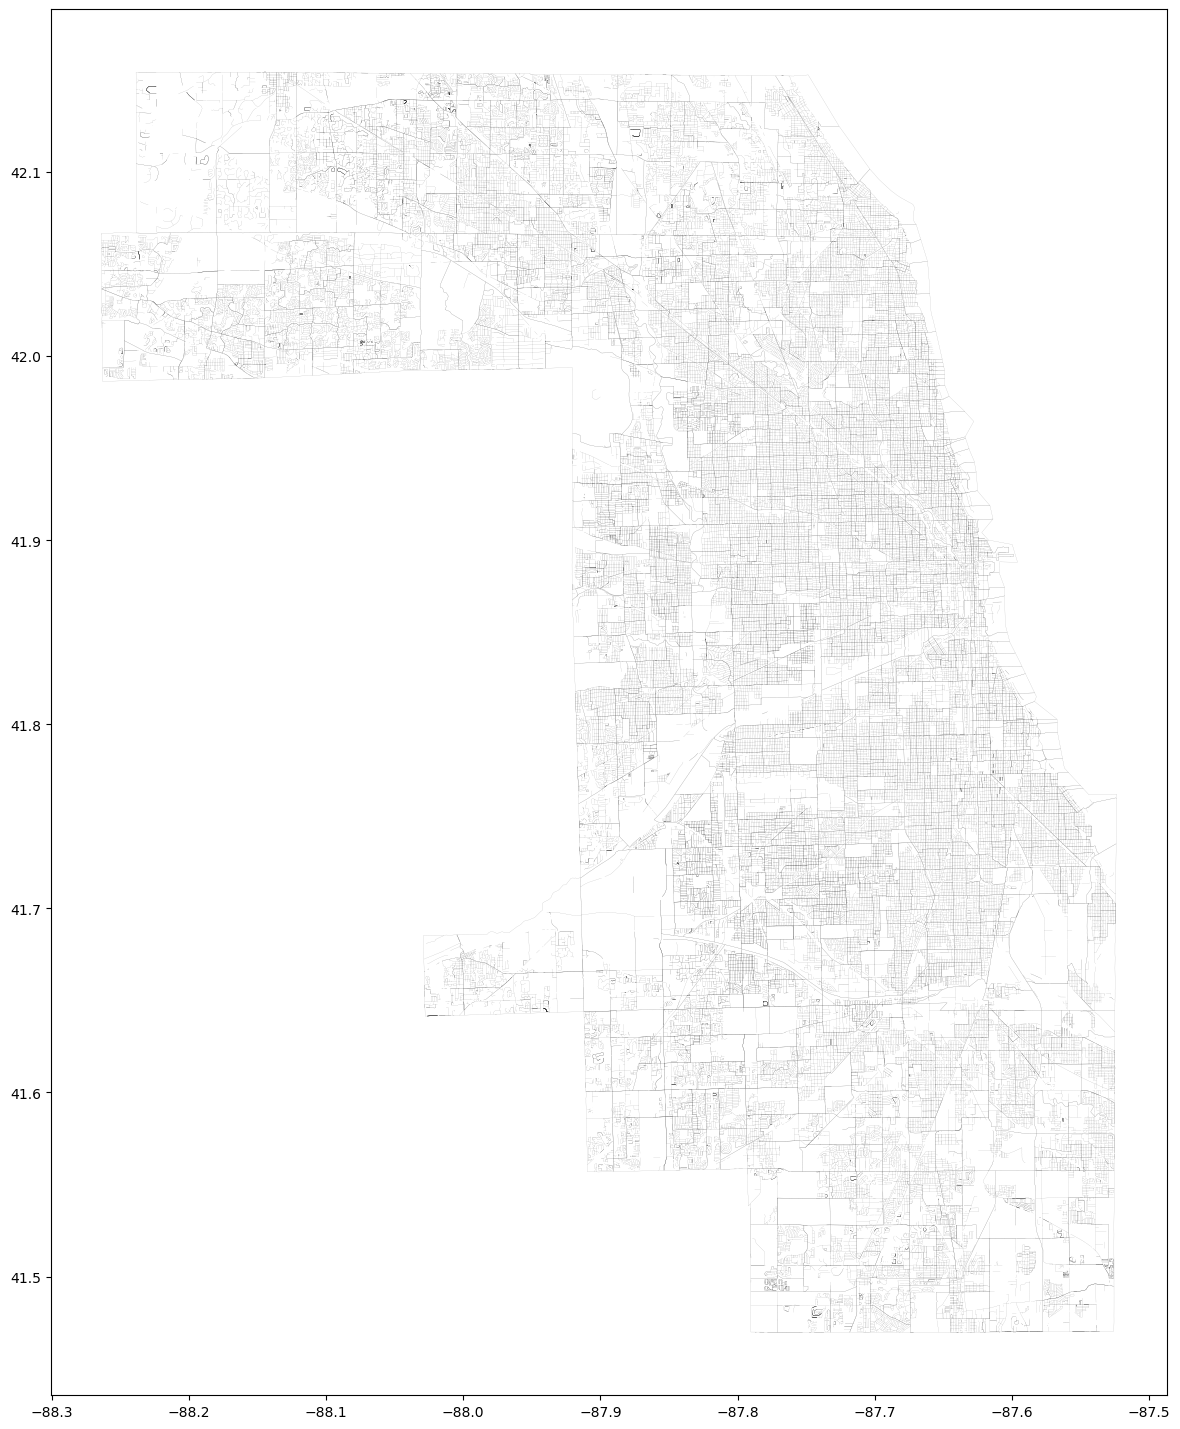

In [77]:
fig_width = 18

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = cc_tract_land_gdf.plot(facecolor="none", edgecolor="grey", linewidth=0.005 * fig_width, ax=ax)
ax = cc_addr_feats22_gdf.plot(facecolor="none", edgecolor="black", linewidth=0.0025 * fig_width, ax=ax)

## Water

### Bodies of Water (areas)

In [78]:
tiger22_water_df = scrape_census_ftp_metadata_page(metadata_url=tiger22_water_url)

In [79]:
print(tiger22_water_df.shape)
tiger22_water_df.head(2)

(3235, 8)


name       last_modified  size description  is_dir  \
1  tl_2022_01001_areawater.zip 2022-10-31 16:05:00  395K               False   
2  tl_2022_01003_areawater.zip 2022-10-31 16:05:00  1.7M               False   

                    clean_name  is_file  \
1  tl_2022_01001_areawater.zip     True   
2  tl_2022_01003_areawater.zip     True   

                                        metadata_url  
1  https://www2.census.gov/geo/tiger/TIGER2022/AR...  
2  https://www2.census.gov/geo/tiger/TIGER2022/AR...

In [80]:
cc_water22_df = tiger22_water_df.loc[tiger22_water_df["name"].str.contains("_17031_")].copy()
cc_water22_df

name       last_modified  size description  \
613  tl_2022_17031_areawater.zip 2022-10-31 16:46:00  392K               

     is_dir                   clean_name  is_file  \
613   False  tl_2022_17031_areawater.zip     True   

                                          metadata_url  
613  https://www2.census.gov/geo/tiger/TIGER2022/AR...

In [81]:
cc_water22_file_path = download_file_from_single_row_metadata_df(file_df=cc_water22_df)

file name: tl_2022_17031_areawater.zip
url:       https://www2.census.gov/geo/tiger/TIGER2022/AREAWATER/tl_2022_17031_areawater.zip


In [82]:
cc_water22_gdf = gpd.read_file(cc_water22_file_path)

In [83]:
print(cc_water22_gdf.shape)
cc_water22_gdf.head(2)

(408, 9)


ANSICODE       HYDROID  FULLNAME  MTFCC  ALAND  AWATER     INTPTLAT  \
0       NaN  110380386029       NaN  H2030      0   66228  +42.0831253   
1       NaN  110380385201  Keene Lk  H2030      0  190257  +42.1343584   

      INTPTLON                                           geometry  
0  -88.1601390  POLYGON ((-88.16540 42.08249, -88.16533 42.082...  
1  -88.1469798  POLYGON ((-88.15463 42.13135, -88.15454 42.131...

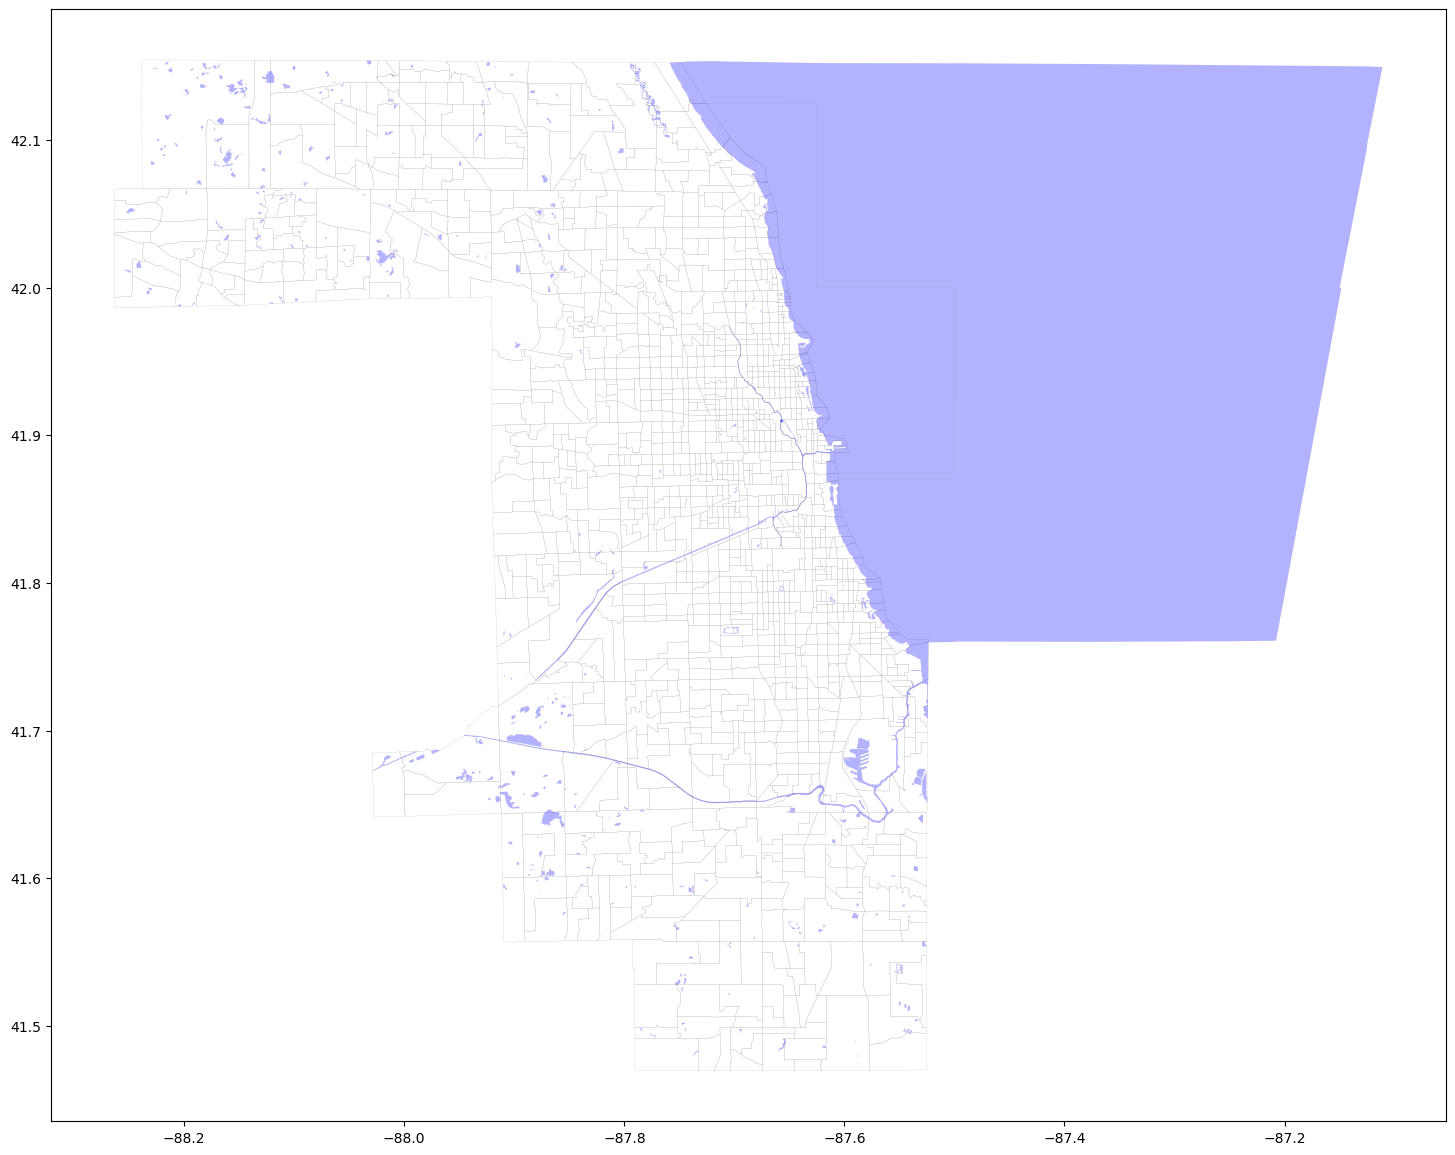

In [84]:
fig_width = 18

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = cc_tract_land_gdf.plot(facecolor="none", edgecolor="grey", linewidth=0.005 * fig_width, ax=ax)
ax = cc_water22_gdf.plot(facecolor="blue", alpha=0.3, edgecolor="black", linewidth=0.0025 * fig_width, ax=ax)

### Waterways (linear)

In [85]:
tiger22_linear_water_df = scrape_census_ftp_metadata_page(metadata_url=tiger22_water_edges_url)

In [86]:
print(tiger22_linear_water_df.shape)
tiger22_linear_water_df.head(2)

(3233, 8)


name       last_modified  size description  \
1  tl_2022_01001_linearwater.zip 2022-10-31 16:05:00  1.7M               
2  tl_2022_01003_linearwater.zip 2022-10-31 16:05:00  1.7M               

   is_dir                     clean_name  is_file  \
1   False  tl_2022_01001_linearwater.zip     True   
2   False  tl_2022_01003_linearwater.zip     True   

                                        metadata_url  
1  https://www2.census.gov/geo/tiger/TIGER2022/LI...  
2  https://www2.census.gov/geo/tiger/TIGER2022/LI...

In [87]:
cc_linear_water22_df = tiger22_linear_water_df.loc[tiger22_linear_water_df["name"].str.contains("_17031_")].copy()
cc_linear_water22_df

name       last_modified  size description  \
613  tl_2022_17031_linearwater.zip 2022-10-31 16:46:00  426K               

     is_dir                     clean_name  is_file  \
613   False  tl_2022_17031_linearwater.zip     True   

                                          metadata_url  
613  https://www2.census.gov/geo/tiger/TIGER2022/LI...

In [88]:
cc_linear_water22_file_path = download_file_from_single_row_metadata_df(file_df=cc_linear_water22_df)

file name: tl_2022_17031_linearwater.zip
url:       https://www2.census.gov/geo/tiger/TIGER2022/LINEARWATER/tl_2022_17031_linearwater.zip


In [89]:
cc_linear_water22_gdf = gpd.read_file(cc_linear_water22_file_path)

In [90]:
print(cc_linear_water22_gdf.shape)
cc_linear_water22_gdf.head(2)

(347, 6)


ANSICODE       LINEARID    FULLNAME ARTPATH  MTFCC  \
0       NaN   110380302256  Spring Crk       N  H3010   
1       NaN  1102215260425   Thorn Crk       N  H3010   

                                            geometry  
0  LINESTRING (-88.21076 42.14590, -88.21058 42.1...  
1  LINESTRING (-87.63274 41.51435, -87.63231 41.5...

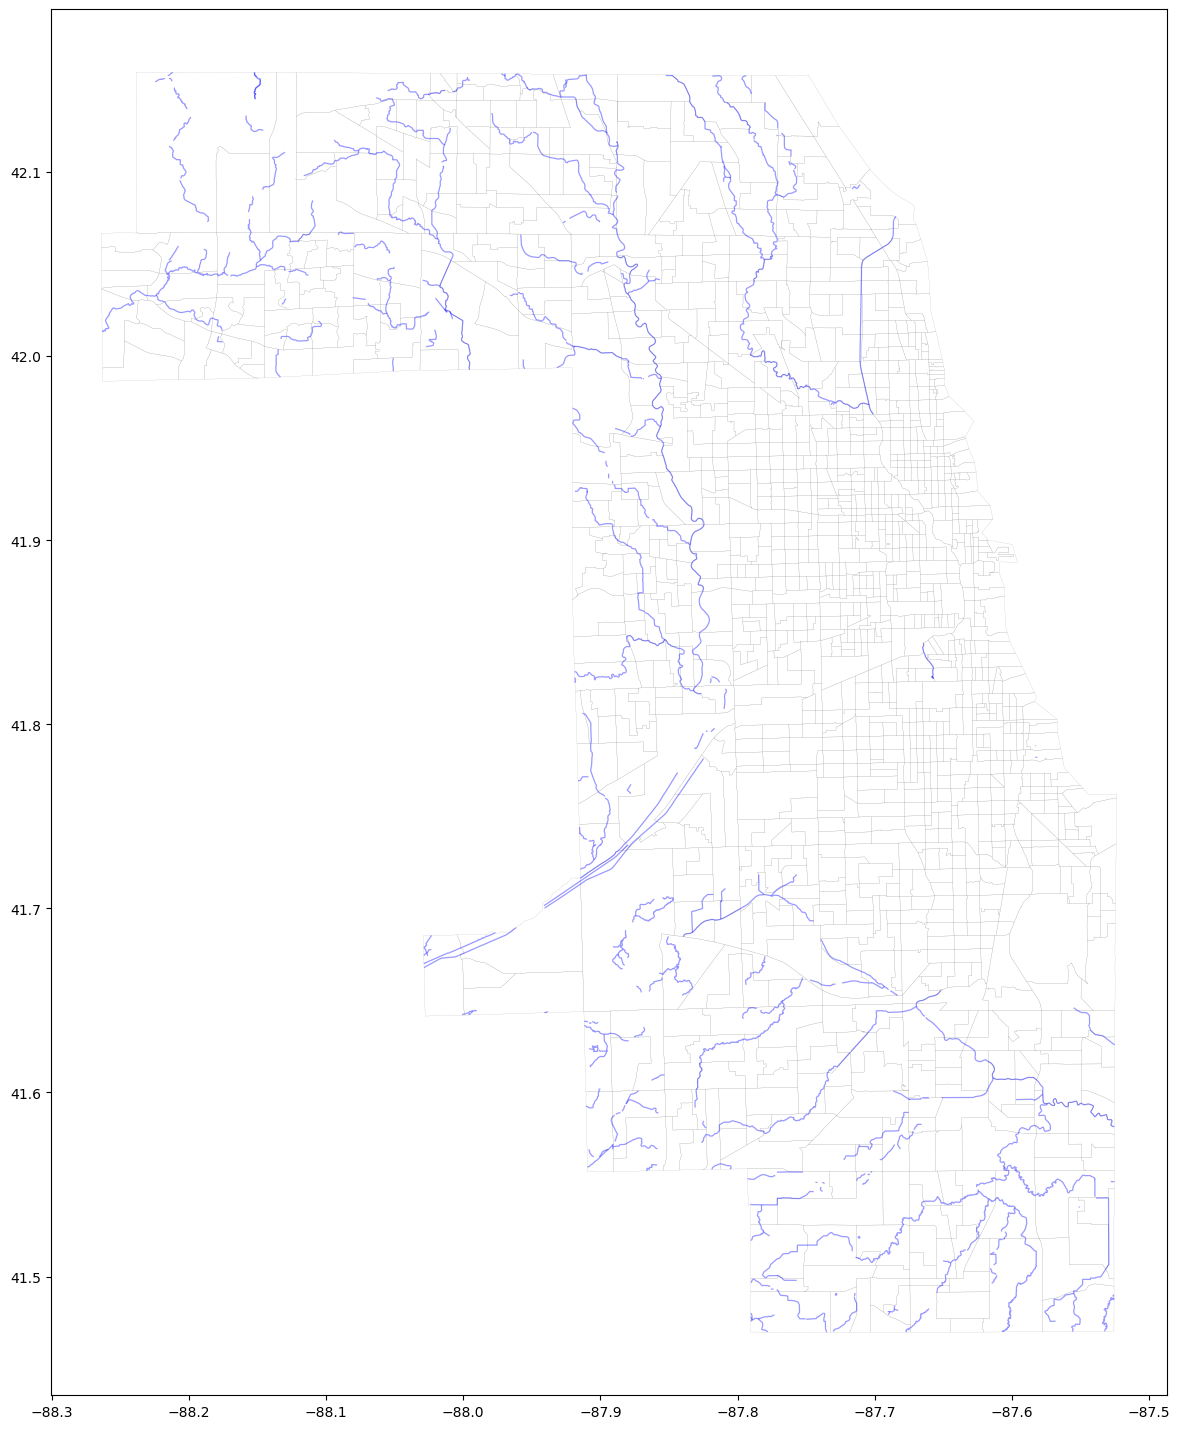

In [91]:
fig_width = 18

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = cc_tract_land_gdf.plot(facecolor="none", edgecolor="grey", linewidth=0.005 * fig_width, ax=ax)
ax = cc_linear_water22_gdf.plot(alpha=0.4, edgecolor="blue", linewidth=0.05 * fig_width, ax=ax)

I assume **Crk** (in the `FULLNAME` column) means "creek". I wonder what the other waterway categories are.

In [92]:
cc_linear_water22_gdf["FULLNAME"].str.split(" ")

0          [Spring, Crk]
1           [Thorn, Crk]
2           [Thorn, Crk]
3             [3rd, Crk]
4           [North, Crk]
             ...        
342    [Mc, Donald, Crk]
343       [Buffalo, Crk]
344         [Stony, Crk]
345        [Navajo, Crk]
346     [Melvina, Ditch]
Name: FULLNAME, Length: 347, dtype: object

In [93]:
cc_linear_water22_gdf["FULLNAME"].str.split(" ").str.len().value_counts(dropna=False)

FULLNAME
2.0    160
NaN     92
3.0     50
4.0     40
5.0      3
7.0      2
Name: count, dtype: int64

In [94]:
cc_linear_water22_gdf["FULLNAME"].isnull().sum()

92

In [95]:
cc_linear_water22_gdf["FULLNAME"].str.split(" ").str[-1].value_counts(dropna=False)

FULLNAME
Crk          161
NaN           92
Riv           30
Ditch         22
Br            20
Cnl            4
Frk            4
Chnnl          4
Slough         2
Lk             2
Tributary      2
Lagoon         1
Lynwood        1
Melissa        1
Lagoons        1
Name: count, dtype: int64

Lots of creeks, some Nulls, some rivers, some drainage ditches, some brooks (?), and a few canals, frks (??), channels, sloughs (?), lakes, tributaries, a couple lagoon(s), and apparently two lakes (Lynwood and Melissa) where the naming standard wasn't obeyed.

In [96]:
cc_linear_water22_gdf.loc[cc_linear_water22_gdf["FULLNAME"].str.contains("Lynwood|Melissa", na=False)]

ANSICODE      LINEARID    FULLNAME ARTPATH  MTFCC  \
211       NaN  110380309825  Lk Lynwood       N  H3010   
256       NaN  110380310680  Lk Melissa       N  H3010   

                                              geometry  
211  LINESTRING (-87.55068 41.53796, -87.55079 41.5...  
256  LINESTRING (-88.16662 42.15158, -88.16661 42.1...

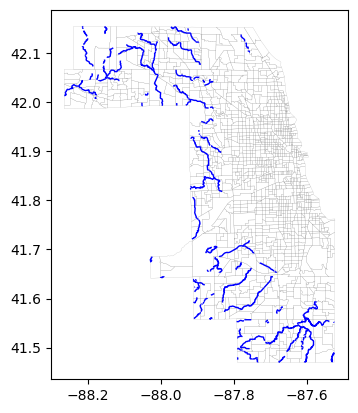

In [97]:
gdf = cc_linear_water22_gdf.loc[
    cc_linear_water22_gdf["FULLNAME"].str.contains("Crk", na=False)
]
ax = gdf.plot(edgecolor="blue", linewidth=1)
ax = cc_tract_land_gdf.plot(facecolor="none", edgecolor="grey", linewidth=0.1, ax=ax)

In [98]:
gdf["FULLNAME"].value_counts(dropna=False)

FULLNAME
Poplar Crk                              15
Salt Crk                                12
Long Run Crk                            12
Hickory Crk                             10
Marley Crk                              10
3rd Crk                                  8
Spring Crk                               7
Silver Crk                               6
Mill Crk                                 6
Addison Crk                              5
Buffalo Crk                              5
Black Partridge Crk                      4
Thorn Crk                                4
Willow Crk                               4
Higgins Crk                              3
Wellers Crk                              3
Deer Crk                                 3
Stony Crk                                3
Crooked Crk                              3
Skokie Crk                               3
Flag Crk                                 3
Crystal Crk                              3
Mc Donald Crk                            3
Ch

Hmm, I guess I don't know the name of any creek in Cook County.

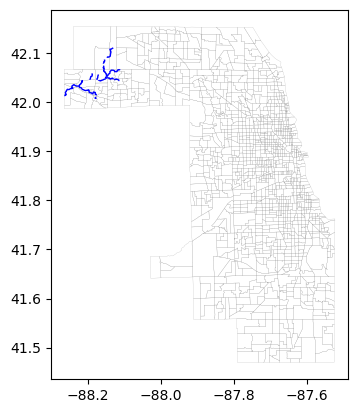

In [99]:
gdf = cc_linear_water22_gdf.loc[cc_linear_water22_gdf["FULLNAME"] == "Poplar Crk"]
ax = gdf.plot(edgecolor="blue", linewidth=1)
ax = cc_tract_land_gdf.plot(facecolor="none", edgecolor="grey", linewidth=0.1, ax=ax)

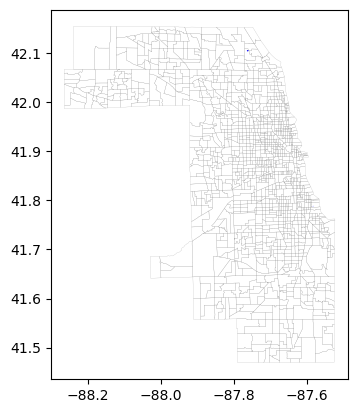

In [100]:
gdf = cc_linear_water22_gdf.loc[
    cc_linear_water22_gdf["FULLNAME"].str.contains("Lagoon", na=False)
]
ax = gdf.plot(edgecolor="blue", linewidth=1)
ax = cc_tract_land_gdf.plot(facecolor="none", edgecolor="grey", linewidth=0.1, ax=ax)

In [101]:
gdf

ANSICODE      LINEARID        FULLNAME ARTPATH  MTFCC  \
52        NaN  110380283241     East Lagoon       N  H3010   
323       NaN  110380368385  Skokie Lagoons       N  H3010   

                                              geometry  
52   LINESTRING (-87.58259 41.78818, -87.58265 41.7...  
323  LINESTRING (-87.76239 42.10610, -87.76240 42.1...

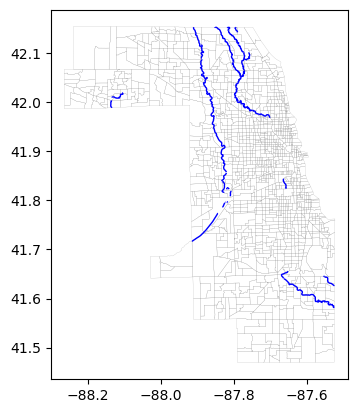

In [102]:
gdf = cc_linear_water22_gdf.loc[
    cc_linear_water22_gdf["FULLNAME"].str.contains("Riv", na=False)
]
ax = gdf.plot(edgecolor="blue", linewidth=1)
ax = cc_tract_land_gdf.plot(facecolor="none", edgecolor="grey", linewidth=0.1, ax=ax)

In [103]:
gdf["FULLNAME"].unique()

array(['Little Calumet Riv', 'Chicago River S Br', 'Des Plaines Riv',
       'Chicago River N Br', 'Skokie Riv', 'Chicago Riv',
       'Chicago River W Frk', 'Middle Fork Nbc Riv', 'Calumet Riv',
       'du Page Riv', 'Grand Calumet Riv'], dtype=object)

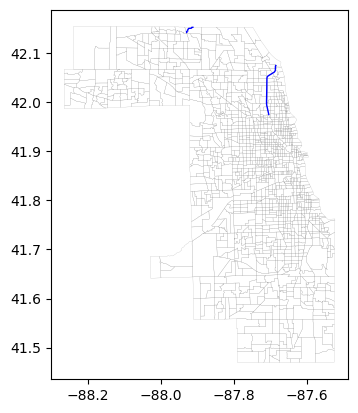

In [104]:
gdf = cc_linear_water22_gdf.loc[
    cc_linear_water22_gdf["FULLNAME"].str.contains("Chnnl", na=False)
]
ax = gdf.plot(edgecolor="blue", linewidth=1)
ax = cc_tract_land_gdf.plot(facecolor="none", edgecolor="grey", linewidth=0.1, ax=ax)

In [105]:
gdf

ANSICODE      LINEARID                                 FULLNAME ARTPATH  \
170       NaN  110380369464           William Rogers Diversion Chnnl       N   
305       NaN  110380369974  William Rogers Memorial Diversion Chnnl       N   
306       NaN  110380369465            William Rogers Memorial Chnnl       N   
314       NaN  110380350603                        North Shore Chnnl       N   

     MTFCC                                           geometry  
170  H3020  LINESTRING (-87.92671 42.14427, -87.92652 42.1...  
305  H3020  LINESTRING (-87.92505 42.14814, -87.92475 42.1...  
306  H3020  LINESTRING (-87.92671 42.14423, -87.92706 42.1...  
314  H3010  LINESTRING (-87.68457 42.07612, -87.68499 42.0...

### Coastline

In [106]:
tiger22_coastline_df = scrape_census_ftp_metadata_page(metadata_url=tiger22_coastline_url)

In [107]:
print(tiger22_coastline_df.shape)
tiger22_coastline_df.head(2)

(1, 8)


name       last_modified size description  is_dir  \
1  tl_2022_us_coastline.zip 2022-10-31 19:41:00  16M               False   

                 clean_name  is_file  \
1  tl_2022_us_coastline.zip     True   

                                        metadata_url  
1  https://www2.census.gov/geo/tiger/TIGER2022/CO...

In [108]:
us_coastline22_file_path = download_file_from_single_row_metadata_df(file_df=tiger22_coastline_df)

file name: tl_2022_us_coastline.zip
url:       https://www2.census.gov/geo/tiger/TIGER2022/COASTLINE/tl_2022_us_coastline.zip


In [109]:
us_coastline22_gdf = gpd.read_file(us_coastline22_file_path)

In [110]:
print(us_coastline22_gdf.shape)
us_coastline22_gdf.head(2)

(4236, 3)


NAME  MTFCC                                           geometry
0  Atlántico  L4150  LINESTRING (-65.99280 18.45854, -65.99323 18.4...
1       Gulf  L4150  LINESTRING (-94.99855 29.62073, -94.99826 29.6...

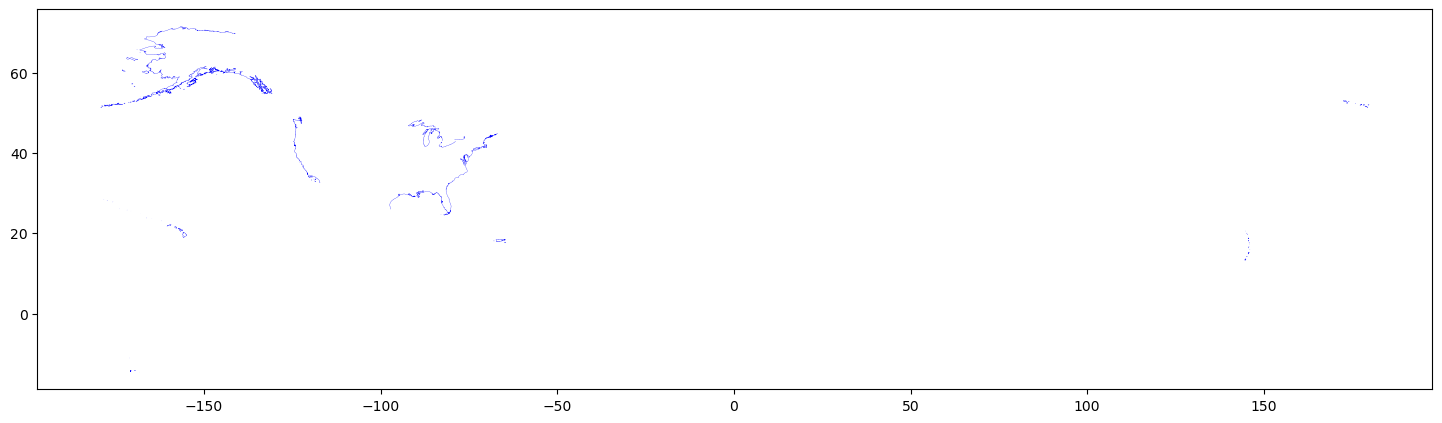

In [111]:
fig_width = 18

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = us_coastline22_gdf.plot(facecolor="none", edgecolor="blue", linewidth=0.01 * fig_width, ax=ax)

Let's bring that in a little bit.

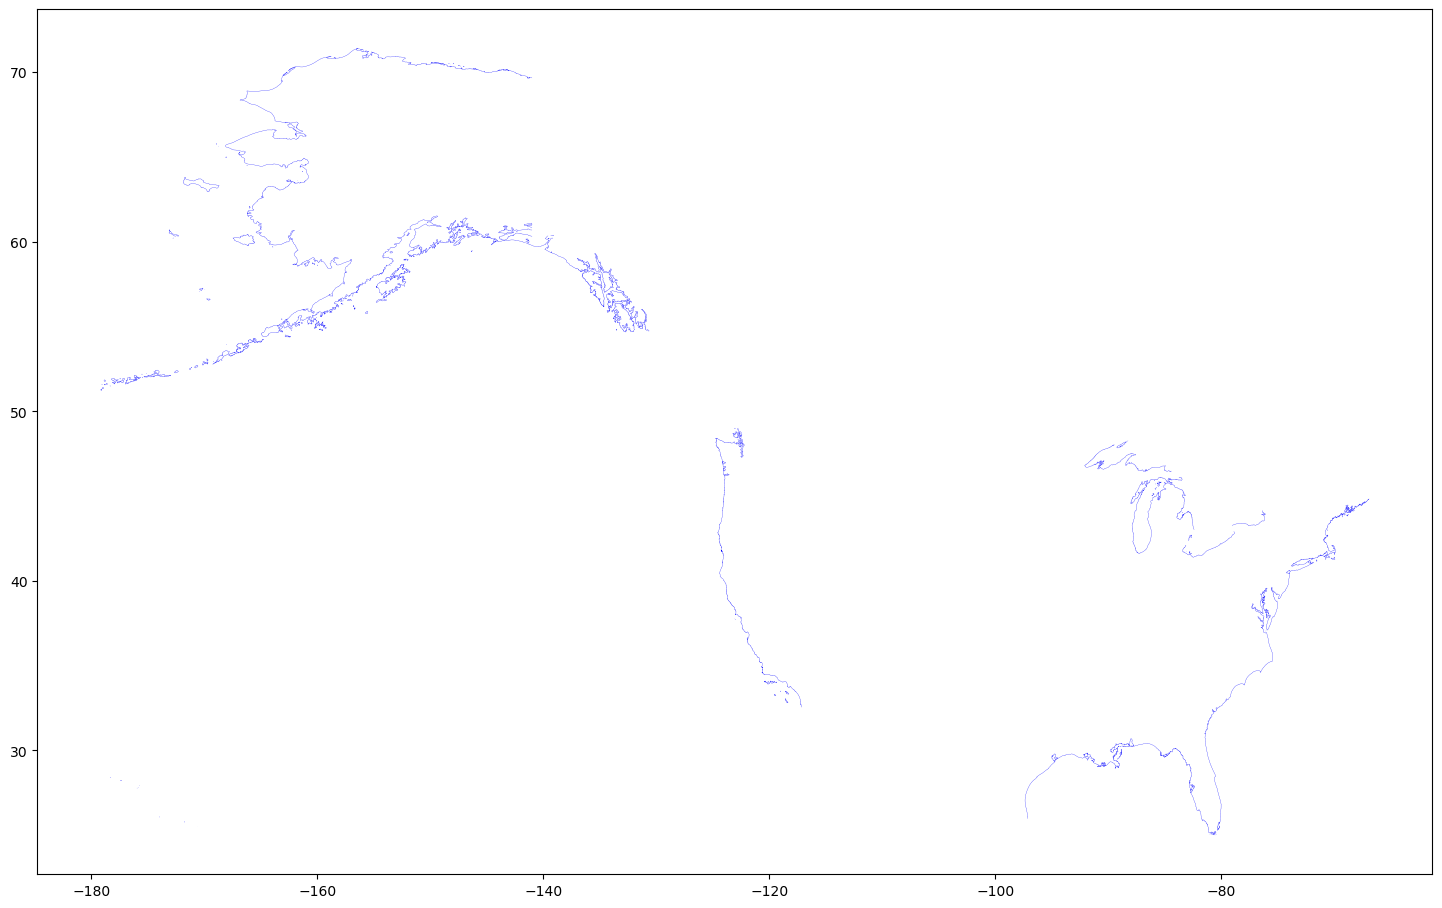

In [112]:
fig_width = 18

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = us_coastline22_gdf.loc[
    (us_coastline22_gdf.geometry.bounds.maxx < -55) & (us_coastline22_gdf.geometry.bounds.minx > -200) &
    (us_coastline22_gdf.geometry.bounds.maxy < 75) & (us_coastline22_gdf.geometry.bounds.miny > 25)
].plot(facecolor="none", edgecolor="blue", linewidth=0.01 * fig_width, ax=ax)

For fun, let's see how fine the resolution is.

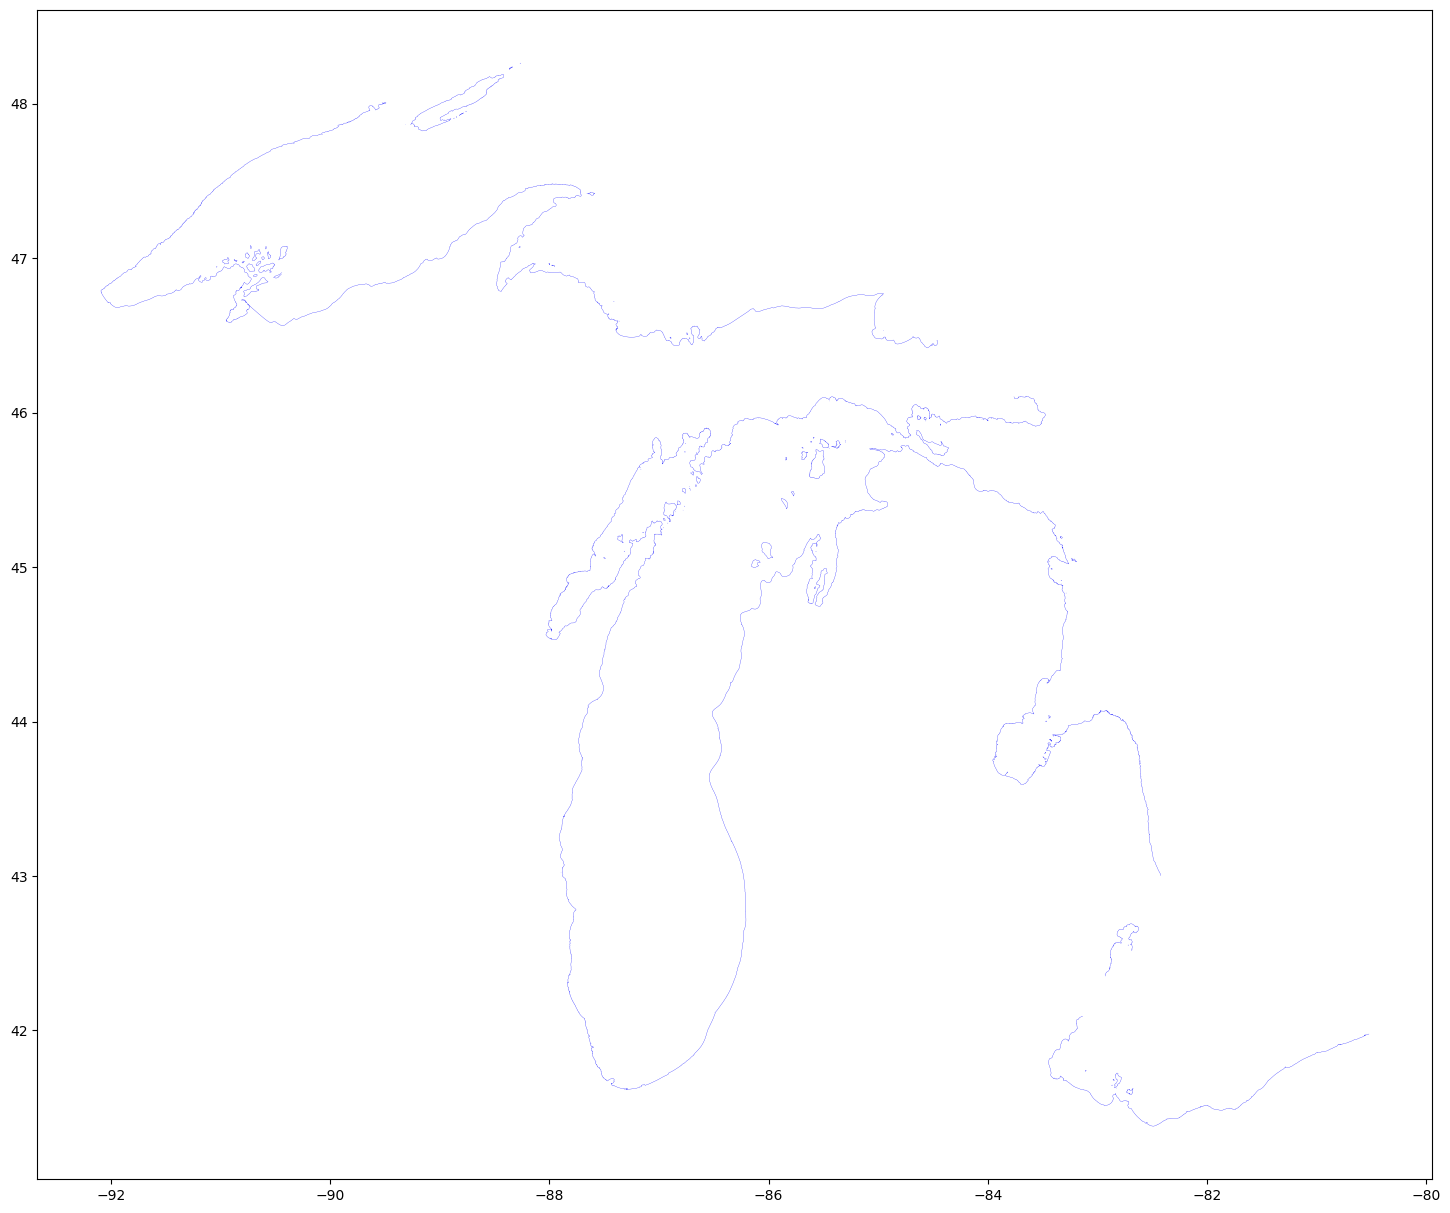

In [113]:
fig_width = 18

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = us_coastline22_gdf.loc[
    (us_coastline22_gdf.geometry.bounds.maxx < -80) & (us_coastline22_gdf.geometry.bounds.minx > -95) &
    (us_coastline22_gdf.geometry.bounds.maxy < 50) & (us_coastline22_gdf.geometry.bounds.miny > 40)
].plot(facecolor="none", edgecolor="blue", linewidth=0.01 * fig_width, ax=ax)

Pretty decent resolution. I've zoomed really far into the cluster of islands in the southwest corner of Lake Superior and I haven't reached the full resolution yet. Neat.

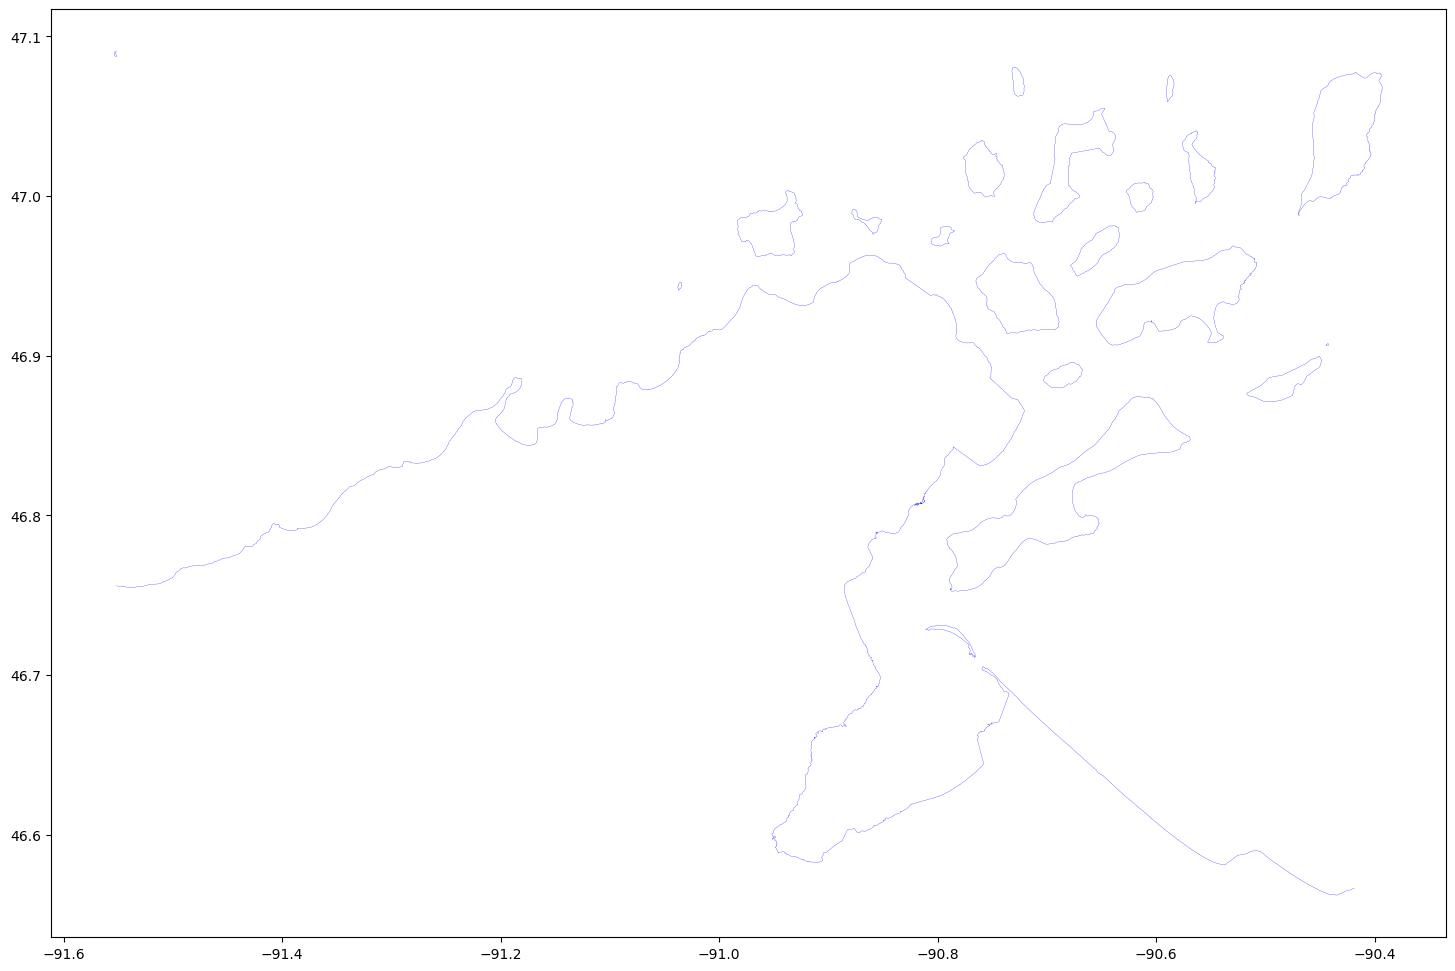

In [114]:
fig_width = 18

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = us_coastline22_gdf.loc[
    (us_coastline22_gdf.geometry.bounds.maxx < -90) & (us_coastline22_gdf.geometry.bounds.minx > -91.75) &
    (us_coastline22_gdf.geometry.bounds.maxy < 47.1) & (us_coastline22_gdf.geometry.bounds.miny > 46.25)
].plot(facecolor="none", edgecolor="blue", linewidth=0.01 * fig_width, ax=ax)

## Landmarks

### Area Landmarks

I don't really know what to expect from this data

In [115]:
tiger22_landmarks_df = scrape_census_ftp_metadata_page(metadata_url=tiger22_area_landmarks_url)

In [116]:
print(tiger22_landmarks_df.shape)
tiger22_landmarks_df.head(2)

(56, 8)


name       last_modified  size description  is_dir  \
1  tl_2022_01_arealm.zip 2022-10-31 19:41:00  865K               False   
2  tl_2022_02_arealm.zip 2022-10-31 19:42:00   22M               False   

              clean_name  is_file  \
1  tl_2022_01_arealm.zip     True   
2  tl_2022_02_arealm.zip     True   

                                        metadata_url  
1  https://www2.census.gov/geo/tiger/TIGER2022/AR...  
2  https://www2.census.gov/geo/tiger/TIGER2022/AR...

In [117]:
il_landmarks22_df = tiger22_landmarks_df.loc[tiger22_landmarks_df["name"].str.contains("_17_")].copy()
il_landmarks22_df

name       last_modified  size description  is_dir  \
14  tl_2022_17_arealm.zip 2022-10-31 19:43:00  1.7M               False   

               clean_name  is_file  \
14  tl_2022_17_arealm.zip     True   

                                         metadata_url  
14  https://www2.census.gov/geo/tiger/TIGER2022/AR...

In [118]:
il_landmarks22_file_path = download_file_from_single_row_metadata_df(file_df=il_landmarks22_df)

file name: tl_2022_17_arealm.zip
url:       https://www2.census.gov/geo/tiger/TIGER2022/AREALM/tl_2022_17_arealm.zip


In [119]:
il_landmarks22_gdf = gpd.read_file(il_landmarks22_file_path)

In [120]:
print(il_landmarks22_gdf.shape)
il_landmarks22_gdf.head(2)

(4055, 11)


STATEFP  ANSICODE         AREAID                        FULLNAME  MTFCC  \
0      17       NaN  1109097729169  Black Partridge Forest (Ccfpd)  K2180   
1      17       NaN  1107052318644   Sunset Memorial Gardens Cmtry  K2582   

     ALAND  AWATER     INTPTLAT     INTPTLON PARTFLG  \
0  1718341  103856  +41.6799470  -88.0155670       N   
1       32       0  +42.3489948  -89.0405174       N   

                                            geometry  
0  POLYGON ((-88.02897 41.68524, -88.02680 41.685...  
1  POLYGON ((-89.04053 42.34906, -89.04051 42.349...

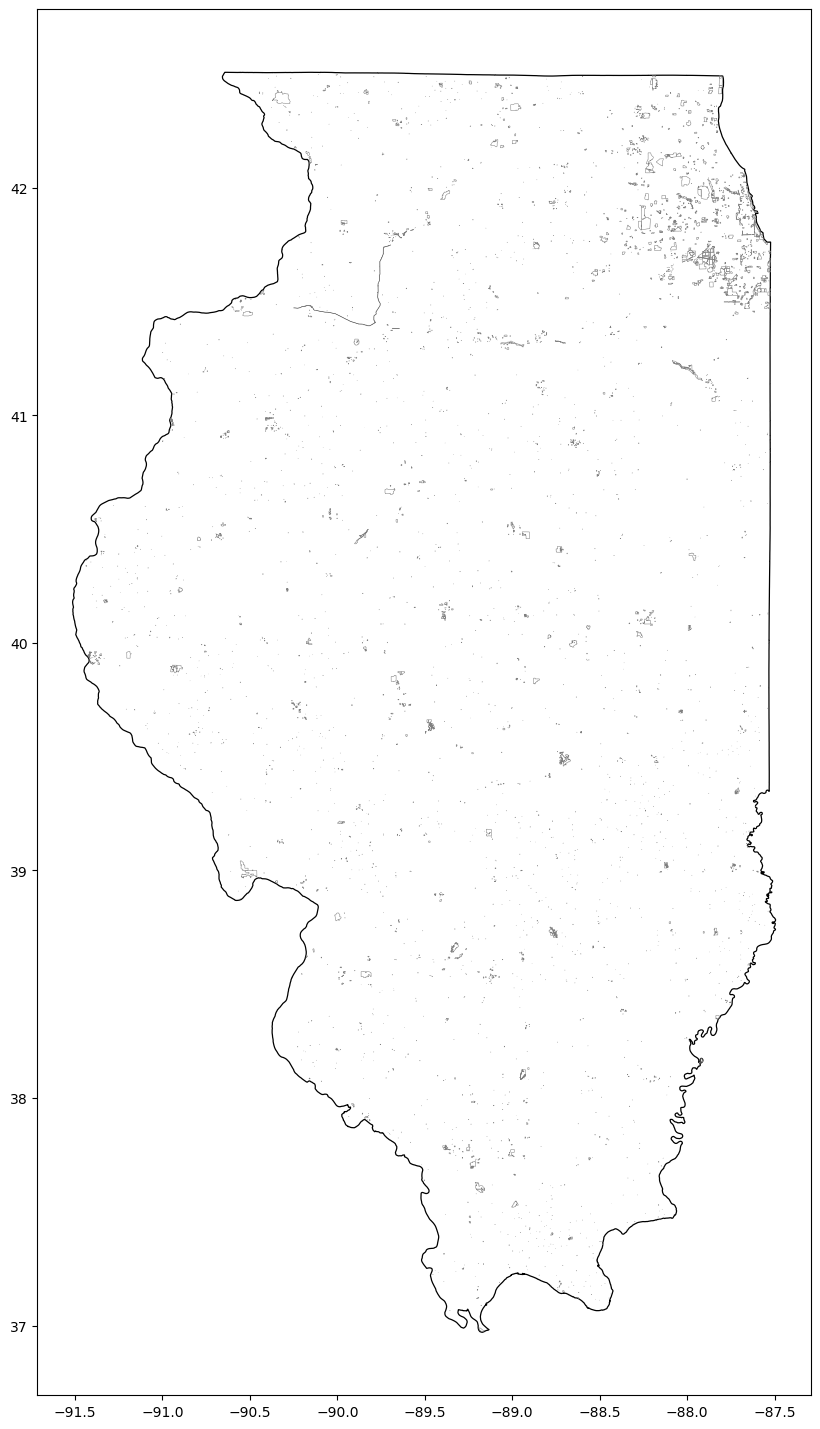

In [121]:
fig_width = 18

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = il_state_boundary.plot(facecolor="none", edgecolor="black", linewidth=0.05 * fig_width, ax=ax)
ax = il_landmarks22_gdf.plot(facecolor="none", edgecolor="grey", linewidth=0.02 * fig_width, ax=ax)

### Point Landmarks


In [122]:
tiger22_pt_landmarks_df = scrape_census_ftp_metadata_page(metadata_url=tiger22_point_landmarks_url)

In [123]:
print(tiger22_pt_landmarks_df.shape)
tiger22_pt_landmarks_df.head(2)

(56, 8)


name       last_modified  size description  is_dir  \
1  tl_2022_01_pointlm.zip 2022-10-31 19:41:00  274K               False   
2  tl_2022_02_pointlm.zip 2022-10-31 19:42:00  285K               False   

               clean_name  is_file  \
1  tl_2022_01_pointlm.zip     True   
2  tl_2022_02_pointlm.zip     True   

                                        metadata_url  
1  https://www2.census.gov/geo/tiger/TIGER2022/PO...  
2  https://www2.census.gov/geo/tiger/TIGER2022/PO...

In [124]:
il_pt_landmarks22_df = tiger22_pt_landmarks_df.loc[tiger22_pt_landmarks_df["name"].str.contains("_17_")].copy()
il_pt_landmarks22_df

name       last_modified  size description  is_dir  \
14  tl_2022_17_pointlm.zip 2022-10-31 19:43:00  1.0M               False   

                clean_name  is_file  \
14  tl_2022_17_pointlm.zip     True   

                                         metadata_url  
14  https://www2.census.gov/geo/tiger/TIGER2022/PO...

In [125]:
il_pt_landmarks22_file_path = download_file_from_single_row_metadata_df(file_df=il_pt_landmarks22_df)

file name: tl_2022_17_pointlm.zip
url:       https://www2.census.gov/geo/tiger/TIGER2022/POINTLM/tl_2022_17_pointlm.zip


In [126]:
il_pt_landmarks22_gdf = gpd.read_file(il_pt_landmarks22_file_path)

In [127]:
print(il_pt_landmarks22_gdf.shape)
il_pt_landmarks22_gdf.head(2)

(35868, 6)


STATEFP ANSICODE        POINTID                  FULLNAME  MTFCC  \
0      17      NaN  1102178508714  Churchhill Ct Cul-De-Sac  C3061   
1      17      NaN  1102181536512                       NaN  C3061   

                     geometry  
0  POINT (-89.00833 40.51230)  
1  POINT (-87.91069 42.40834)

In [128]:
il_named_pt_landmarks22_gdf = il_pt_landmarks22_gdf.loc[il_pt_landmarks22_gdf["FULLNAME"].notnull()].copy()
print(f"Point landmark records with a non-null name: {len(il_named_pt_landmarks22_gdf)}")
print(f"Distinct Point landmark names: {il_named_pt_landmarks22_gdf['FULLNAME'].nunique()}")

Point landmark records with a non-null name: 15810
Distinct Point landmark names: 12995


In [129]:
il_named_pt_landmarks22_gdf.head(10)

STATEFP  ANSICODE        POINTID                  FULLNAME  MTFCC  \
0       17       NaN  1102178508714  Churchhill Ct Cul-De-Sac  C3061   
10      17       NaN  1102180441404      Oriole Ct Cul-De-Sac  C3061   
45      17  00422806  1102663145983                  Hildreth  C3081   
46      17  00414891  1102664199123             Oakland Cmtry  K2582   
47      17  00414892  1102664199237             Oakland Cmtry  K2582   
48      17  00414890  1102664199349    Oakland Freeport Cmtry  K2582   
49      17  00414836  1102664199562             Oaklawn Cmtry  K2582   
50      17  01737636  1102664199662             Oaklawn Cmtry  K2582   
51      17  01807831  1102664199856             Oaklawn Cmtry  K2582   
52      17  01748074  1102664199932       Oakleaf Memorial Pk  K2582   

                      geometry  
0   POINT (-89.00833 40.51230)  
10  POINT (-88.11368 42.35876)  
45  POINT (-87.83558 39.86559)  
46  POINT (-88.46295 42.31911)  
47  POINT (-89.31178 42.41863)  
48  POINT (-89.66317 42.27863)  
49  POINT (-89.95149 38.75949)  
50  POINT (-88.48117 41.09448)  
51  POINT (-88.75286 41.93725)  
52  POINT (-90.47680 41.39892)

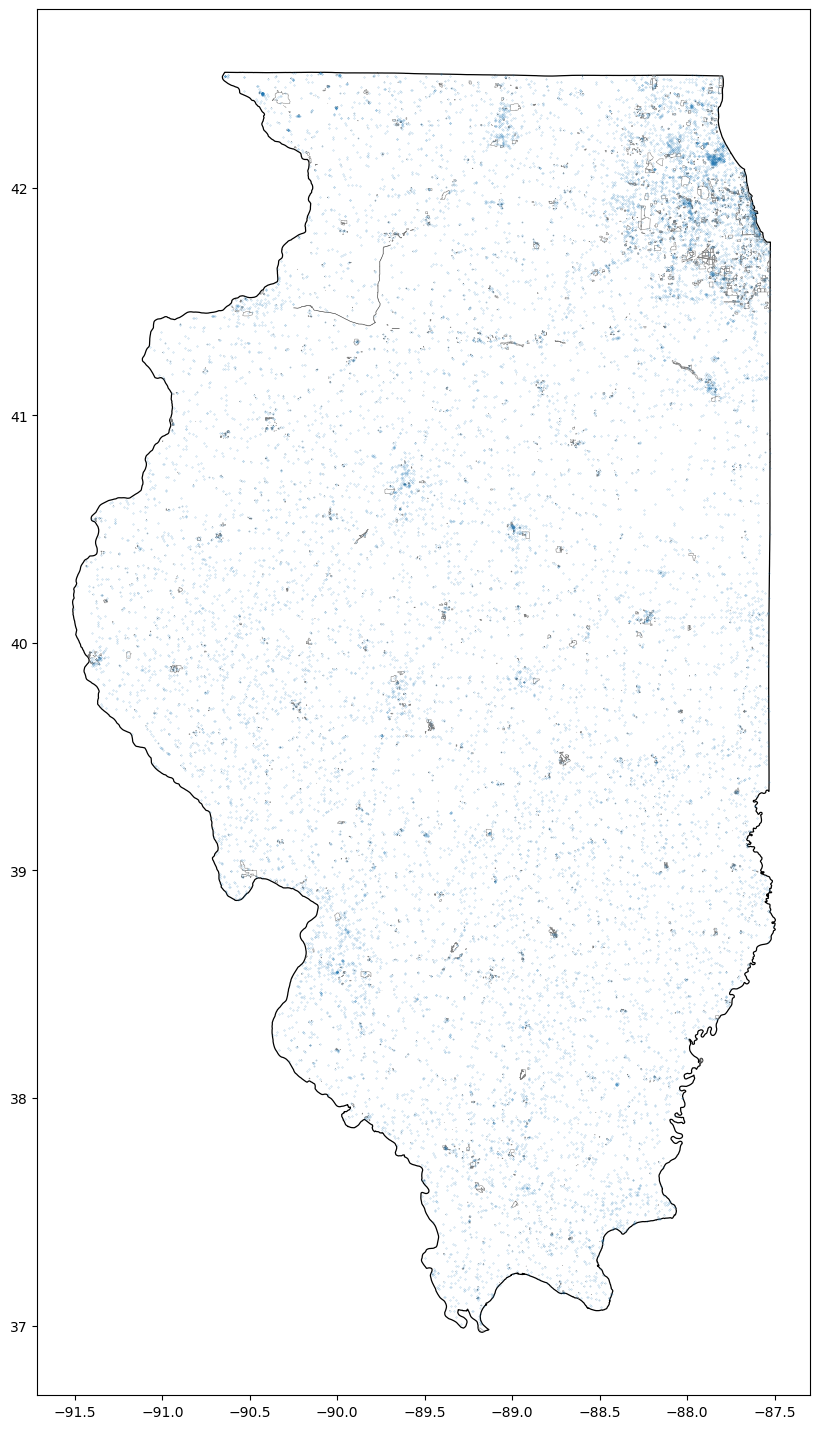

In [130]:
fig_width = 18

fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax = il_state_boundary.plot(facecolor="none", edgecolor="black", linewidth=0.05 * fig_width, ax=ax)
ax = il_landmarks22_gdf.plot(facecolor="none", edgecolor="grey", linewidth=0.02 * fig_width, ax=ax)
ax = il_named_pt_landmarks22_gdf.plot(alpha=0.5, markersize=0.003 * fig_width, ax=ax)